<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/Multivariate_Time_Series_Forecasting_Hands_On.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Thie project aims to illustrate the multivariate time series forecasting methods. Specifically, we will predict the energy demand (load) and price for the next 24 hours in Spain using the following 5 methods:

- XGBoost
  *  Single-Step Single-Output + Autoregressive

- CNN-LSTM-DNN

  *  Single-Step Single-Output + Autoregressive
  *  Single-Step Multi-Output + Autoregressive
  *  Multi-Step Multi-Output (single shot, seq2vec)
  *  Multi-Step Multi-Output (seq2seq)













##  1-Data Preprocessing


In [4]:
## Set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import xgboost as xgb
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing
from joblib import Parallel, delayed
import time

In [5]:
random.seed(42)

In [6]:
# Load the dataset and show its info
df = pd.read_csv('energy_dataset.csv', usecols=['time','total load actual', 'price actual'])
print(f'The shape of the dataset is {df.shape}\n')
print(df.info())

The shape of the dataset is (35064, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35064 non-null  object 
 1   total load actual  35028 non-null  float64
 2   price actual       35064 non-null  float64
dtypes: float64(2), object(1)
memory usage: 821.9+ KB
None


In [7]:
df.head()

time  total load actual  price actual
0  2015-01-01 00:00:00+01:00            25385.0         65.41
1  2015-01-01 01:00:00+01:00            24382.0         64.92
2  2015-01-01 02:00:00+01:00            22734.0         64.48
3  2015-01-01 03:00:00+01:00            21286.0         59.32
4  2015-01-01 04:00:00+01:00            20264.0         56.04

In [8]:
## Parse time column and set index

# Convert to datetime
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time'] = df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Ensure time series is in ascending order
df.sort_index(inplace=True)

# Calculate time differences
time_diffs = df.index.to_series().diff()
irregularities = time_diffs[time_diffs != time_diffs.mode()[0]][1:]             #Identify any irregularities, apart from the first row
if irregularities.empty:
    print("No irregularities found.")
else:
    print("Irregularities found at:")
    print(irregularities)

No irregularities found.


In [9]:
# We are using data from the most recent three years (starting from January 1, 2016) for training, as it provides sufficient information while reducing computational time.
df = df[df.index >= '2016-01-01 00:00:00'].copy()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26303 entries, 2016-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  26294 non-null  float64
 1   price actual       26303 non-null  float64
dtypes: float64(2)
memory usage: 616.5 KB


In [11]:
## Handle Missing Values

non_numeric_values = ['?', 'N/A', '-', ''] # List of non-numeric values to replace

for col in df.columns:
    df[col] = df[col].replace(non_numeric_values, np.nan)
    df[col] = df[col].astype('float64')
# Check out null value situation
df.isna().sum()

total load actual    9
price actual         0
dtype: int64

In [12]:
df[df.isna().any(axis=1)]

total load actual  price actual
time                                                
2016-04-25 03:00:00                NaN         22.65
2016-04-25 05:00:00                NaN         40.18
2016-05-10 21:00:00                NaN         39.11
2016-07-09 20:00:00                NaN         51.72
2016-09-28 07:00:00                NaN         56.40
2017-11-14 11:00:00                NaN         66.17
2017-11-14 18:00:00                NaN         75.45
2018-06-11 16:00:00                NaN         64.93
2018-07-11 07:00:00                NaN         69.79

In [13]:
# Impute the missing values using linear interpolation
df['total load actual'] = df['total load actual'].interpolate(method='linear')

# Check
df.isna().sum()

total load actual    0
price actual         0
dtype: int64

In [14]:
## Check data type again
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26303 entries, 2016-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  26303 non-null  float64
 1   price actual       26303 non-null  float64
dtypes: float64(2)
memory usage: 616.5 KB


All date types are good, no conversion is needed.

## 2-EDA

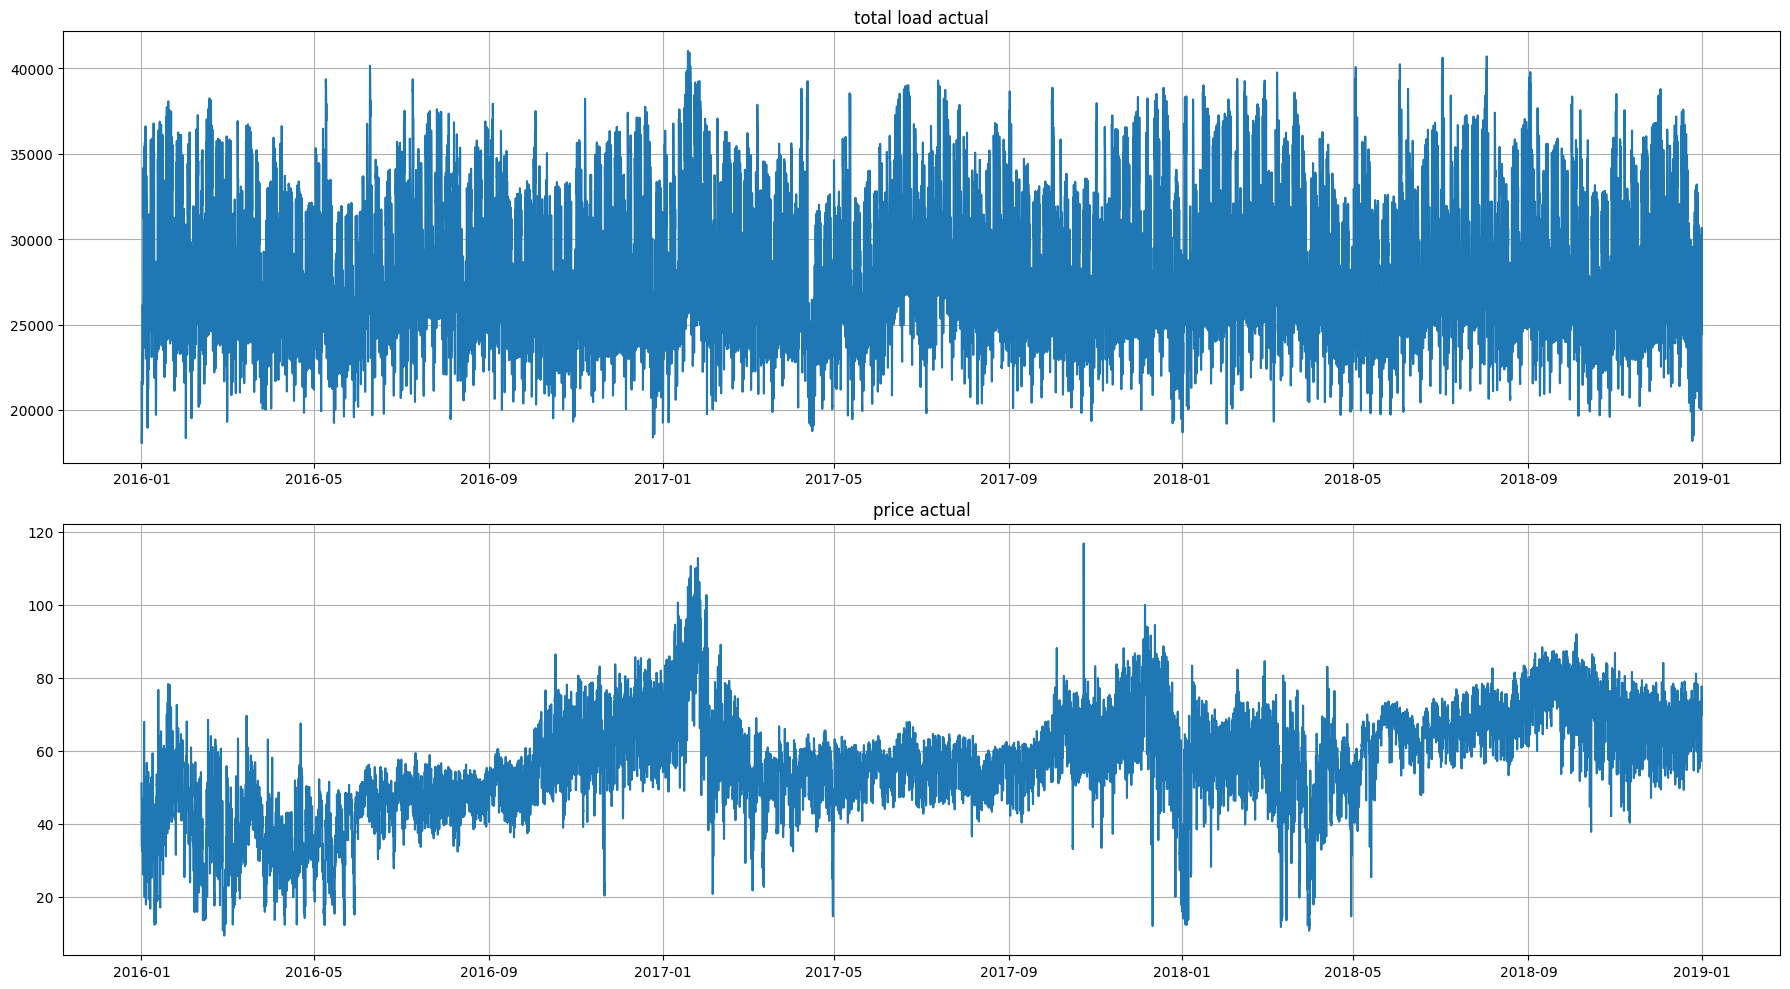

In [15]:
##Visualizing Data

fig, axs = plt.subplots(len(df.columns), 1, figsize=(18, 10)) # Changed the first argument to len(df.columns)

for i, col in enumerate(df.columns):
    axs[i].plot(df[col])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

The plot suggests that load exhibits greater stability compared to price

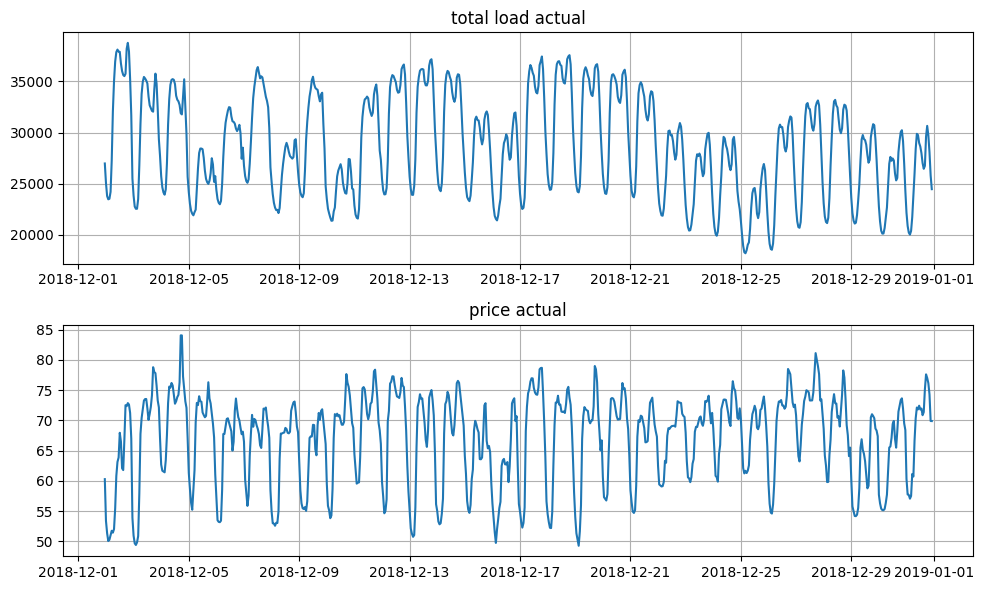

In [16]:
# Visualize the last few daya
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10, 6))

for i, col in enumerate(df.columns):
    axs[i].plot(df[col][-24*30:])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

There are clear seasonal patterns in both curves, and adding time features will likely help models capture these trends.

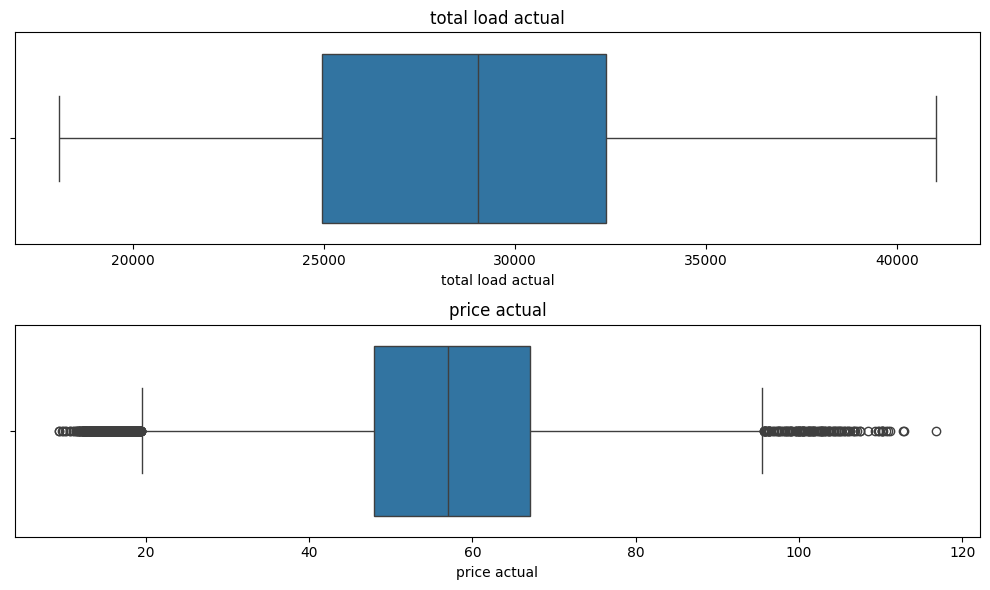

In [17]:
# Check outliers
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10,6))

for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

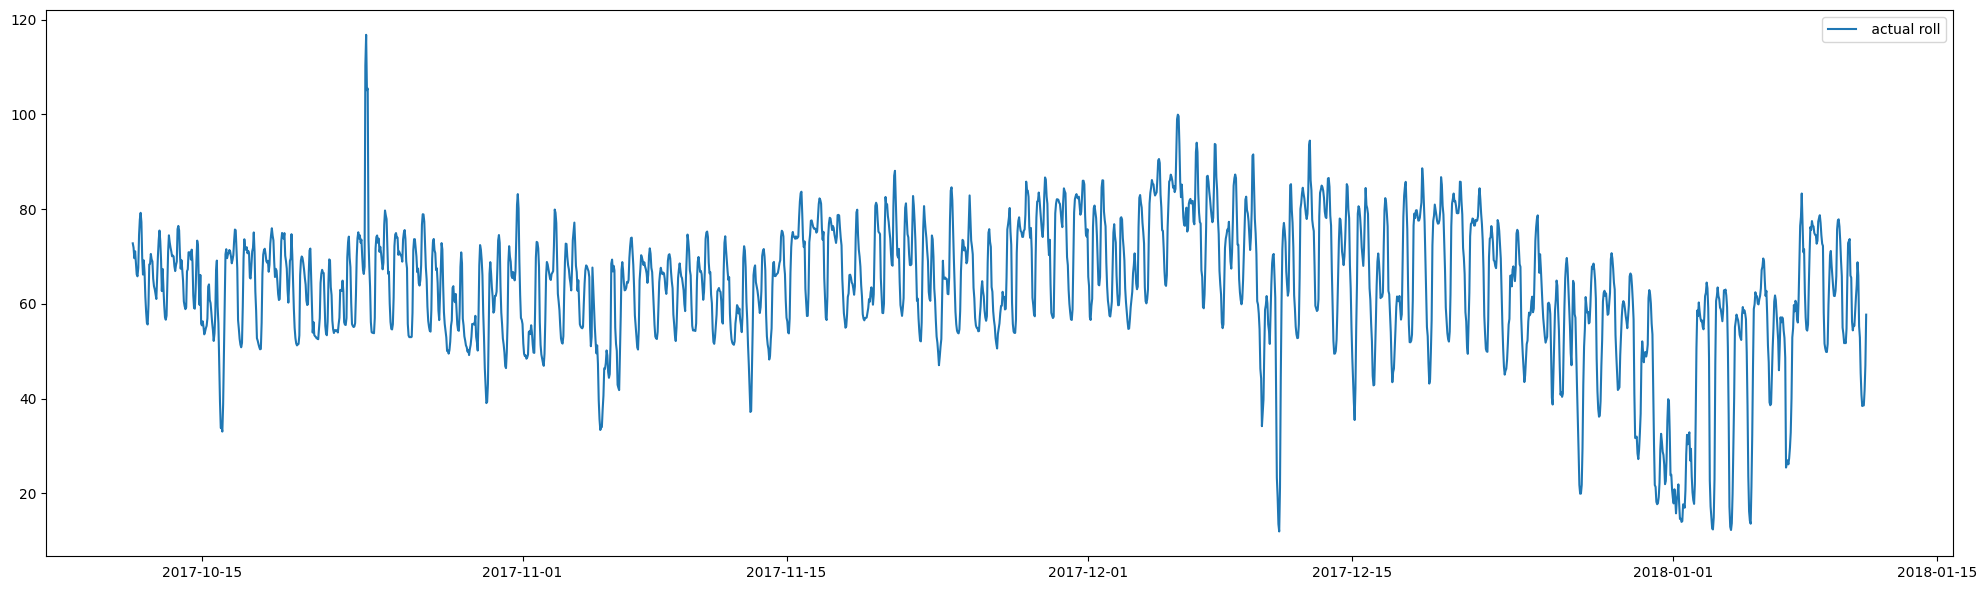

In [18]:
# Visualize the outliers
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual'], label=' actual roll')

plt.legend()
plt.tight_layout()
plt.show()

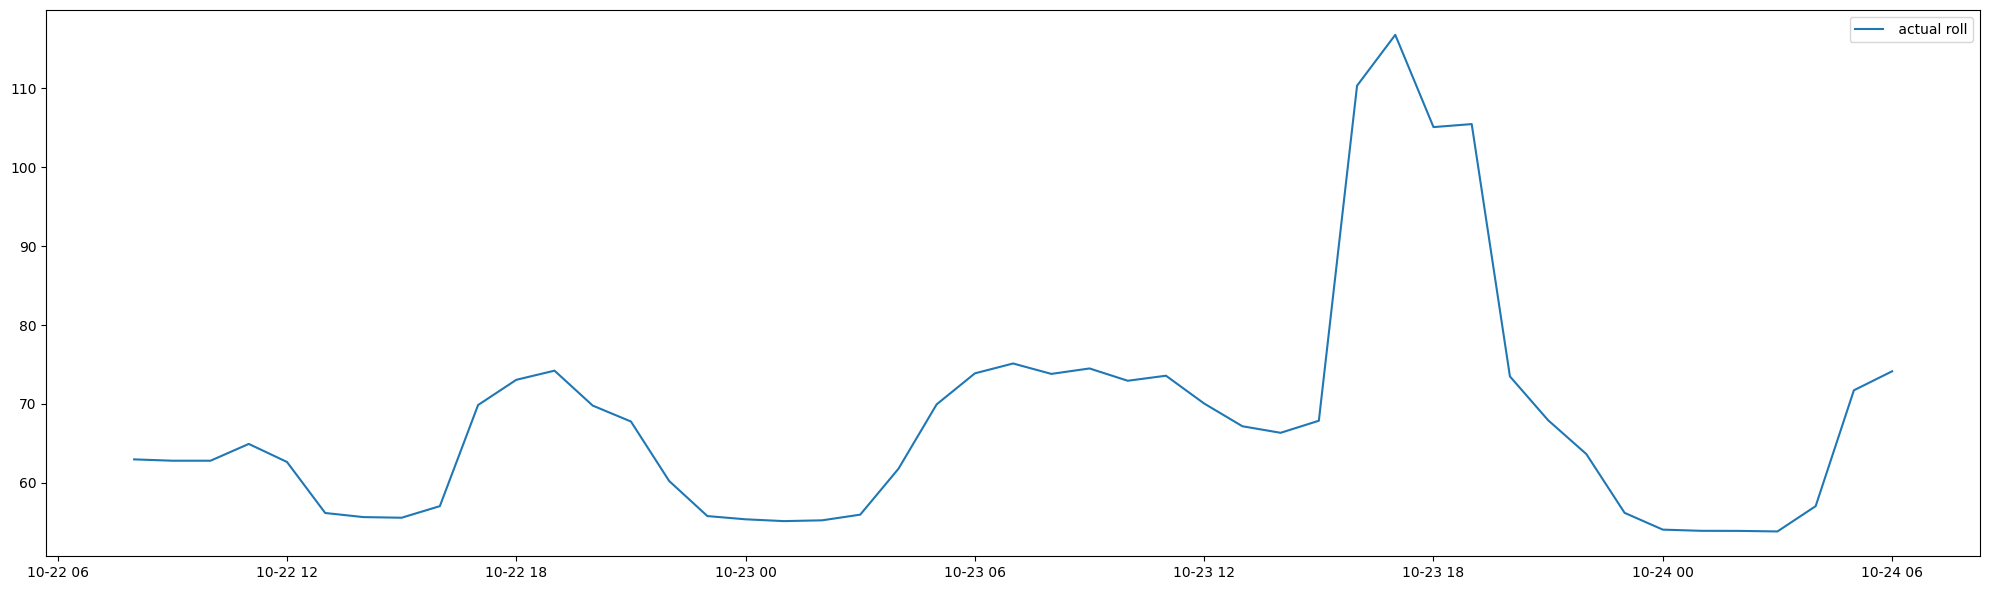

In [19]:
# Zoom in and visualize the outliers
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-22 07:00:00') & (df.index < '2017-10-24 07:00:00')]['price actual'], label=' actual roll')

plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Statistics
df.describe().transpose()

count          mean          std       min       25%  \
total load actual  26303.0  28810.257138  4545.474497  18054.00  24932.50   
price actual       26303.0     56.726108    14.592461      9.33     47.99   

                       50%       75%      max  
total load actual  29016.0  32371.00  41015.0  
price actual          57.0     67.02    116.8

The features are on different scales, so we need to apply scaling.

## 3-Feature Engineering

In [21]:
# Add some extra features

def add_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

df = add_time_features(df)

In [22]:
# Correlation
df.corr() # The results show that 'hour' and 'dayofweek' are indeed higyly related to our desired targets, it would be helpful to improve our models to include these columns

total load actual  price actual      hour  dayofweek
total load actual           1.000000      0.409105  0.394732  -0.196502
price actual                0.409105      1.000000  0.212474  -0.157526
hour                        0.394732      0.212474  1.000000   0.000095
dayofweek                  -0.196502     -0.157526  0.000095   1.000000

In [23]:
## Smooth features

original_cols = ['total load actual', 'price actual']
rolling_size = 8
for col in original_cols:
    df[f'{col} rolling'] = df[col].rolling(window=rolling_size).mean()
df.dropna(inplace=True)

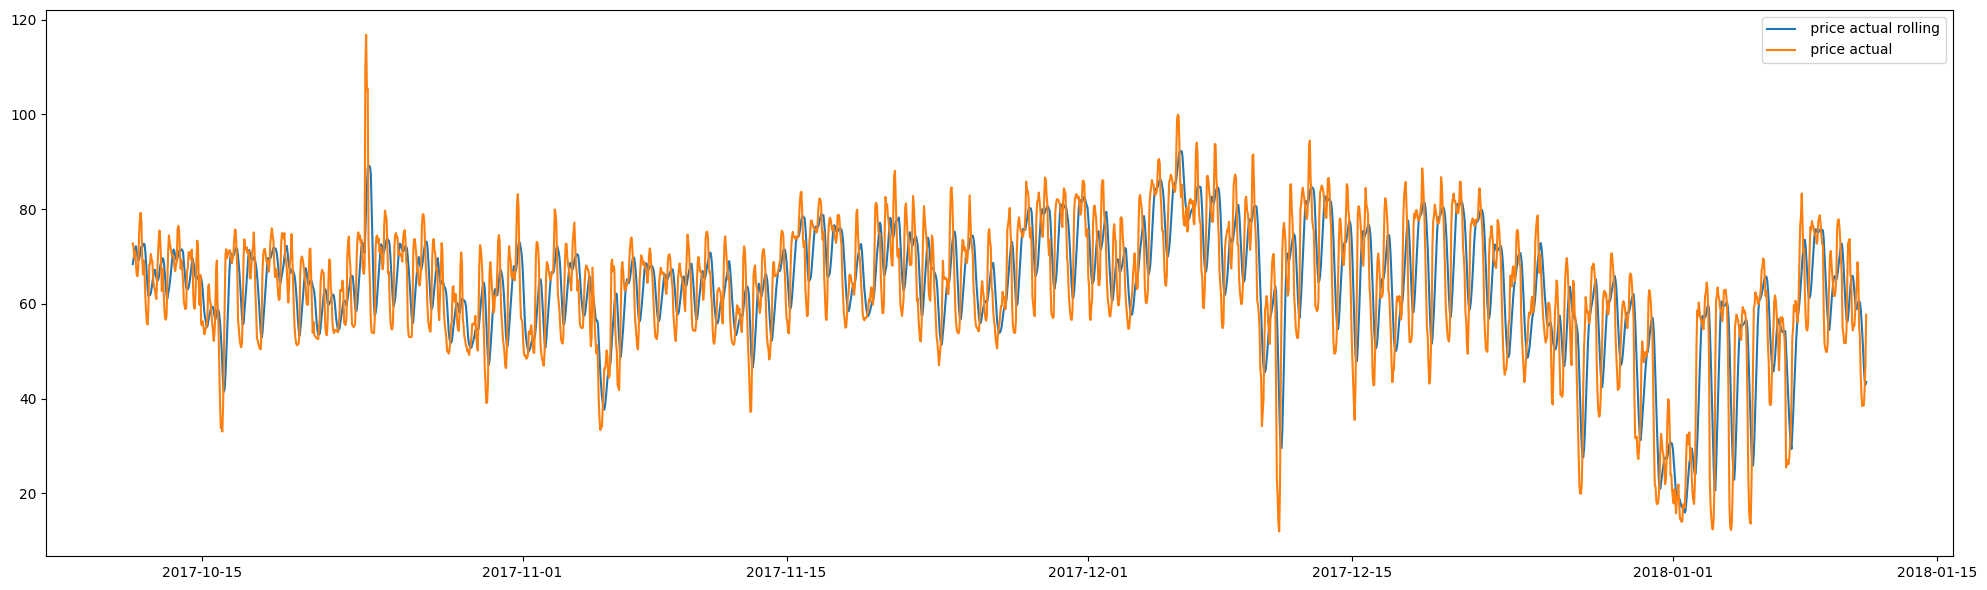

In [24]:
# Visualize part of the data again
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual rolling'], label=' price actual rolling')
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual'], label=' price actual')

plt.legend()
plt.tight_layout()
plt.show()

In [25]:
## Train Test Split

# Calculate the split indices once
split_step = int(df.shape[0] * 0.8)
evaluate_step = int((df.shape[0] - split_step) * 0.5)

# Split the dataset
train = df.iloc[:split_step].copy()
evaluate = df.iloc[split_step:].copy()
valid, test = evaluate.iloc[:evaluate_step].copy(), evaluate.iloc[evaluate_step:].copy() # validation and test datasets

# For XGBoost
train_xgb, valid_xgb, test_xgb = train.copy(), valid.copy(), test.copy()




# For CNN-LSTM-DNN

## Scaling

# Initialize the scalers
rolling_scaler = MinMaxScaler()
load_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

rolling_columns = ['total load actual rolling', 'price actual rolling',]
for col in rolling_columns:
    train.loc[:,f'{col} scaled'] = rolling_scaler.fit_transform(train[[col]])
    valid.loc[:,f'{col} scaled'] = rolling_scaler.transform(valid[[col]])
    test.loc[:,f'{col} scaled'] = rolling_scaler.transform(test[[col]])

train.loc[:,'total load actual scaled'] = load_scaler.fit_transform(train[['total load actual']])
train.loc[:,'price actual scaled'] = price_scaler.fit_transform(train[['price actual']])

valid.loc[:,'total load actual scaled'] = load_scaler.transform(valid[['total load actual']])
valid.loc[:,'price actual scaled'] = price_scaler.transform(valid[['price actual']])
test.loc[:,'total load actual scaled'] = load_scaler.transform(test[['total load actual']])
test.loc[:,'price actual scaled'] = price_scaler.transform(test[['price actual']])

# Drop rolling columns
train.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)
valid.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)
test.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)

# Finally, we get the datasets ready for NN-based machine learning
train_s = train.drop(['total load actual', 'price actual'], axis=1)
valid_s = valid.drop(['total load actual', 'price actual'], axis=1)
test_s = test.drop(['total load actual', 'price actual'], axis=1)

In [26]:
train_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21036 entries, 2016-01-01 07:00:00 to 2018-05-26 18:00:00
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hour                              21036 non-null  int32  
 1   dayofweek                         21036 non-null  int32  
 2   total load actual rolling scaled  21036 non-null  float64
 3   price actual rolling scaled       21036 non-null  float64
 4   total load actual scaled          21036 non-null  float64
 5   price actual scaled               21036 non-null  float64
dtypes: float64(4), int32(2)
memory usage: 986.1 KB


In [27]:
# To save memory, it is sufficient to use float32
train_s = train_s.astype(np.float32)
valid_s = valid_s.astype(np.float32)
test_s = test_s.astype(np.float32)

In [28]:
train_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21036 entries, 2016-01-01 07:00:00 to 2018-05-26 18:00:00
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hour                              21036 non-null  float32
 1   dayofweek                         21036 non-null  float32
 2   total load actual rolling scaled  21036 non-null  float32
 3   price actual rolling scaled       21036 non-null  float32
 4   total load actual scaled          21036 non-null  float32
 5   price actual scaled               21036 non-null  float32
dtypes: float32(6)
memory usage: 657.4 KB


## 4-Model Building

### 4.1 XGBoost

#### Single-Step Single Output

Feature Engineering

In [29]:
# Function to add lagged features
def add_lagged_features(df, lags):
    # Initialize dictionary to store lagged features
    lagged_features = {}

    # Add lagged features for 'total load actual' and 'price actual'
    for lag in range(1, lags+1):
        lagged_features[f'total load actual lag_{lag}'] = df['total load actual'].shift(lag)
        lagged_features[f'price actual lag_{lag}'] = df['price actual'].shift(lag)
        lagged_features[f'total load actual rolling lag_{lag}'] = df['total load actual rolling'].shift(lag)
        lagged_features[f'price actual rolling lag_{lag}'] = df['price actual rolling'].shift(lag)


    # Use pd.concat to add all the lagged features at once
    df = pd.concat([df, pd.DataFrame(lagged_features, index=df.index)], axis=1)

    # Dropping NaN values resulting from shifting operation
    df.dropna(inplace=True)

    return df


# Add lagged features
train_lagged = add_lagged_features(train_xgb, lags=48)
valid_lagged = add_lagged_features(valid_xgb, lags=48)
test_lagged = add_lagged_features(test_xgb, lags=48)

train_x = train_lagged.drop(['total load actual', 'price actual','total load actual rolling', 'price actual rolling'], axis=1)
train_load = train_lagged['total load actual']
train_price = train_lagged['price actual']

valid_x = valid_lagged.drop(['total load actual', 'price actual','total load actual rolling', 'price actual rolling'], axis=1)
valid_load = valid_lagged['total load actual']
valid_price = valid_lagged['price actual']

test_x = test_lagged.drop(['total load actual', 'price actual','total load actual rolling', 'price actual rolling'], axis=1)
test_load = test_lagged['total load actual']
test_price = test_lagged['price actual']


Load-Model

In [ ]:
# Hyperparameter Tuning 1 - Broad Search Range

# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(2, 7, 1),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [500],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

In [ ]:
# Hyperparameter Tuning 2 - Refined Search Range

# Define parameter grid
param_grid = {
    'reg_lambda': [0.1, 0.2, 0.3],
    'reg_alpha': [0.1, 0.2, 0.3],
    'objective': ['reg:squarederror'],
    'max_depth': [5, 6],
    'learning_rate': [0.05, 0.1, 0.3],
    'n_estimators': [500],
    'min_child_weight': [1, 2],
    'gamma': [0.1, 0.2, 0.3],
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

In [ ]:
# Cross-Validation and Final Model Training

dtrain_load = xgb.DMatrix(train_x, label=train_load)

# Define the parameters for the model
parameters = {'reg_lambda': 0.2,
              'reg_alpha': 0.3,
              'objective': 'reg:squarederror',
              'min_child_weight': 1,
              'max_depth': 6,
              'learning_rate': 0.05,
              'gamma': 0.1}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_load,
    num_boost_round=8000,
    nfold=5,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

best_num_boost_round = cv_results['test-rmse-mean'].idxmin()

load_final_model = xgb.train(
    params=parameters,
    dtrain=dtrain_load,
    num_boost_round=best_num_boost_round
)
#load_final_model.save_model('xgb_load_final_model.json')

In [30]:
# Load the model
xgb_load_final_model = xgb.Booster()
xgb_load_final_model.load_model('xgb_load_final_model.json')

# Prediction
dval_load = xgb.DMatrix(valid_x, label=valid_load)
xgb_valid_load_prediction = xgb_load_final_model.predict(dval_load).reshape(-1, 1)


xgb_valid_load = valid_load.values.reshape(-1, 1)

xgb_load_mae = mean_absolute_error(xgb_valid_load_prediction, xgb_valid_load)
xgb_load_mse = mean_squared_error(xgb_valid_load_prediction, xgb_valid_load)
print(f"xgb load mae: {xgb_load_mae}")
print(f"xgb load mse: {xgb_load_mse}")

# load_final_model.save_model('xgb_load_final_model.json')

xgb load mae: 297.13971500411503
xgb load mse: 212450.77544503688


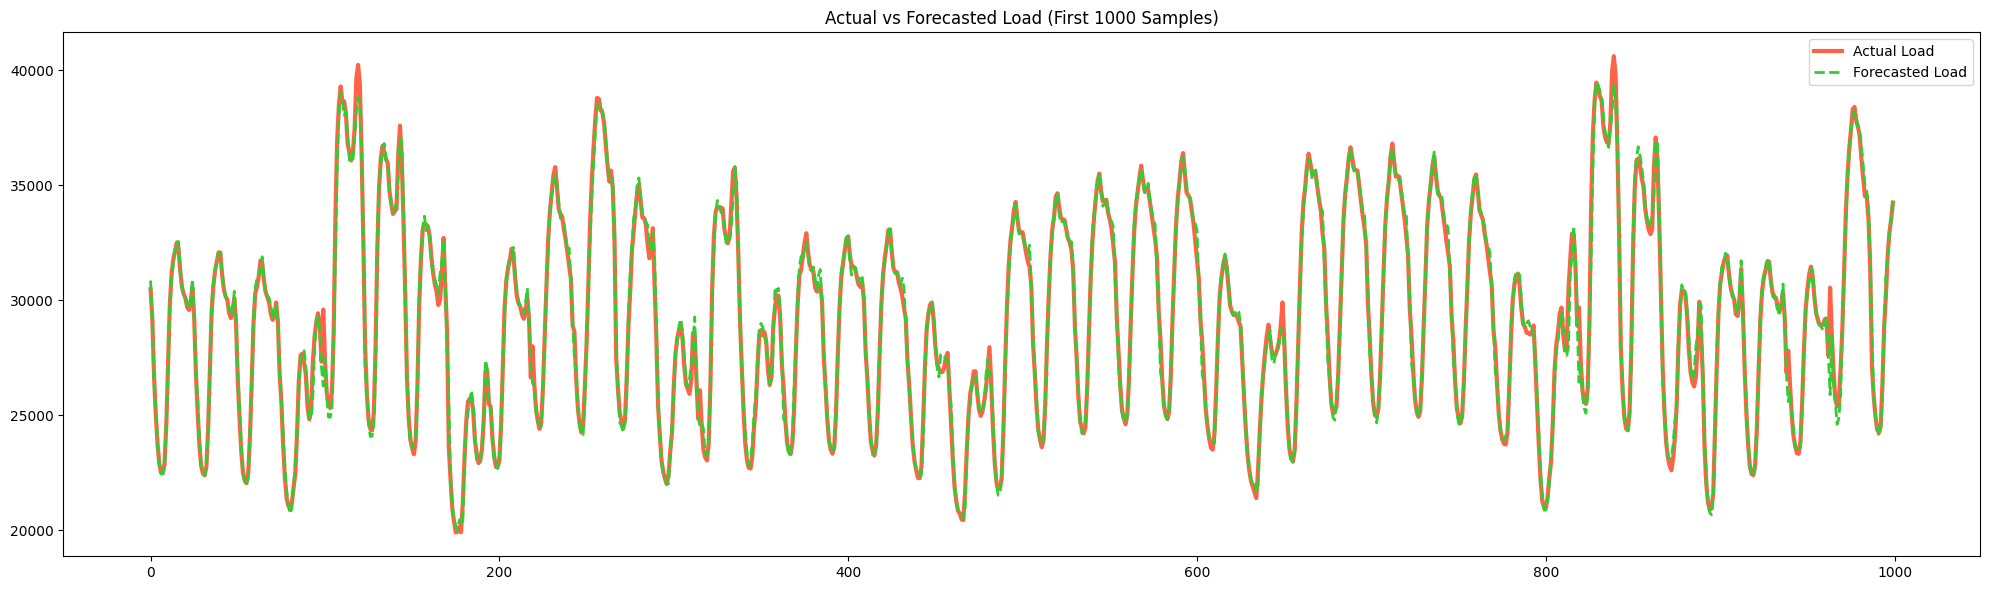

In [31]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(xgb_valid_load[:1000], c='Tomato', label='Actual Load', linestyle='-', linewidth=3)
ax.plot(xgb_valid_load_prediction[:1000], c='LimeGreen', label='Forecasted Load', linestyle='--', linewidth=2)
ax.set_title('Actual vs Forecasted Load (First 1000 Samples)')
plt.legend()
plt.tight_layout()
plt.show()

Price

In [ ]:
# Hyperparamter Tuning

# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(3, 6, 1),
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [800],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for price actual
random_search_price = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_price.fit(train_x, train_price)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_price.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_price.best_score_)))

In [ ]:
dtrain_price = xgb.DMatrix(train_x, label=train_price)

# Define the parameters for the model
parameters = {'reg_lambda': 0.2,
              'reg_alpha': 0.2,
              'objective': 'reg:squarederror',
              'min_child_weight': 5,
              'max_depth': 3,
              'learning_rate': 0.05,
              'gamma': 0.2}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_price,
    num_boost_round=3000,
    nfold=3,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

best_num_boost_round = cv_results['test-rmse-mean'].idxmin()

xgb_price_final_model = xgb.train(
    params=parameters,
    dtrain=dtrain_price,
    num_boost_round=best_num_boost_round
)


In [32]:
xgb_price_final_model = xgb.Booster()
xgb_price_final_model.load_model('xgb_price_final_model.json')

# Prediction
dval_price = xgb.DMatrix(valid_x)
price_prediction = xgb_price_final_model.predict(dval_price).reshape(-1, 1)
price_actual = valid_price.values.reshape(-1, 1)

xgb_price_mae = mean_absolute_error(price_prediction, price_actual)
xgb_price_mse = mean_squared_error(price_prediction, price_actual)

print(f"Price Mean Absolute Error (MAE): {xgb_price_mae}")
print(f"Price Mean Squared Error (MSE): {xgb_price_mse}")


#xgb_price_final_model.save_model('xgb_price_final_model.json')

Price Mean Absolute Error (MAE): 1.2778504338105643
Price Mean Squared Error (MSE): 2.755321672543805


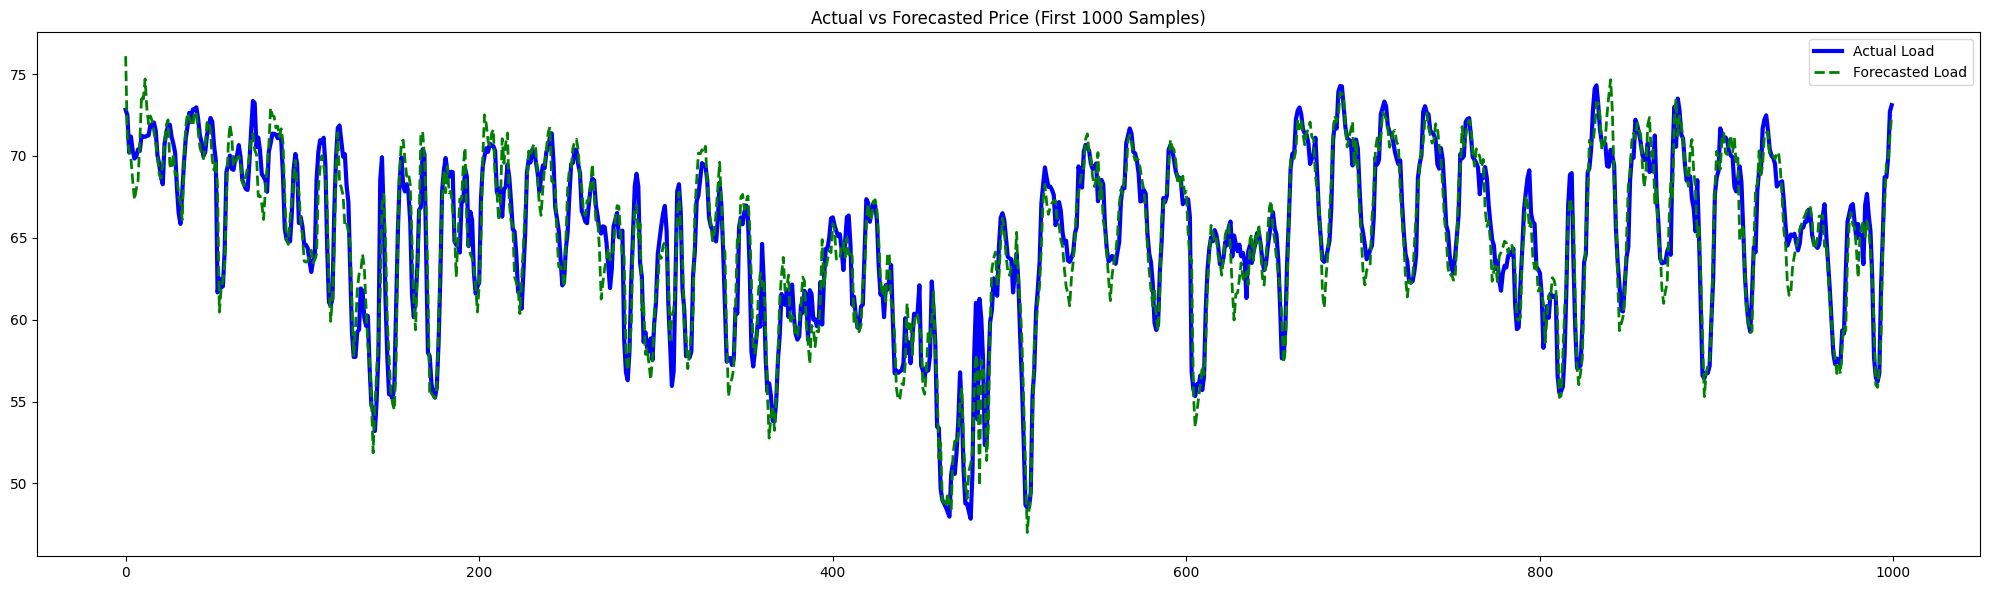

In [33]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(price_actual[:1000], c='blue', label='Actual Load', linestyle='-', linewidth=3)
ax.plot(price_prediction[:1000], c='green', label='Forecasted Load', linestyle='--', linewidth=2)
ax.set_title('Actual vs Forecasted Price (First 1000 Samples)')
plt.legend()
plt.tight_layout()
plt.show()

### 4.2 CNN-LSTM-DNN Single Step

#### Single-Step Single-Output


In [34]:
def single_step_windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, input_columns, output_columns, column_names):
    """Generates dataset windows for single-step forecasting

    Args:
      series (array of float) - The time series data (can be multivariate).
      window_size (int) - Number of time steps in each input window.
      batch_size (int) - Number of samples per batch.
      shuffle_buffer_size (int) - Buffer size for shuffling the dataset.
      input_columns (list of str, or ints) - Column names or indices to be used as features.
      output_columns (str, or ints) - Column names or indices to be used as labels (target variables).
      column_names (list of str, optional) - List of column names in the input dataset.

    Returns:
      dataset (TF Dataset) - A TensorFlow dataset containing feature and label pairs.
    """

    # Specify the postions of input and output features
    if column_names is not None:
        input_columns = [column_names.index(col) if isinstance(col, str) else col for col in input_columns]
        output_columns = [column_names.index(col) if isinstance(col, str) else col for col in output_columns]
    else:
        raise ValueError(f"column_names are missing")


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data, ensuring each window has the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # +1 refers to forecasting 1 time step

    # Flatten the windows into individual sequences
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Map each window to a tuple of (features, labels), where the label is the next time step
    dataset = dataset.map(lambda window: (tf.gather(window[:-1], input_columns, axis=-1),
                                          tf.gather(window[-1], output_columns, axis=-1))) # Here, -1 refers to single step method, we only forecast the next 1 time step

    if shuffle_buffer_size is not None:
        # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches and prefetch to optimize performance
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


# Initialize Parameters
column_names = train_s.columns.to_list()
input_cols = train_s.columns.to_list()
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 24*100 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

Load Model

In [36]:
# Load
output_cols = ['total load actual scaled']

# Customize load model
def create_uncompiled_load_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    return model


def create_load_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=435,
        decay_rate=0.95,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_load_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model


# datasets preparation
train_load_set_ssso = single_step_windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

validation_load_set_ssso = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=None,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

test_load_set_ssso = single_step_windowed_dataset(series=test_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=None,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)




In [ ]:
# Training

single_step_single_output_load_model = create_load_model(initial_lr=1e-1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)
history = single_step_single_output_load_model.fit(train_load_set, validation_data=validation_load_set, epochs=40, callbacks=[early_stopping])

81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step
ssso load mse: 421287.0796235082
ssso load mae: 469.67368440162664


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


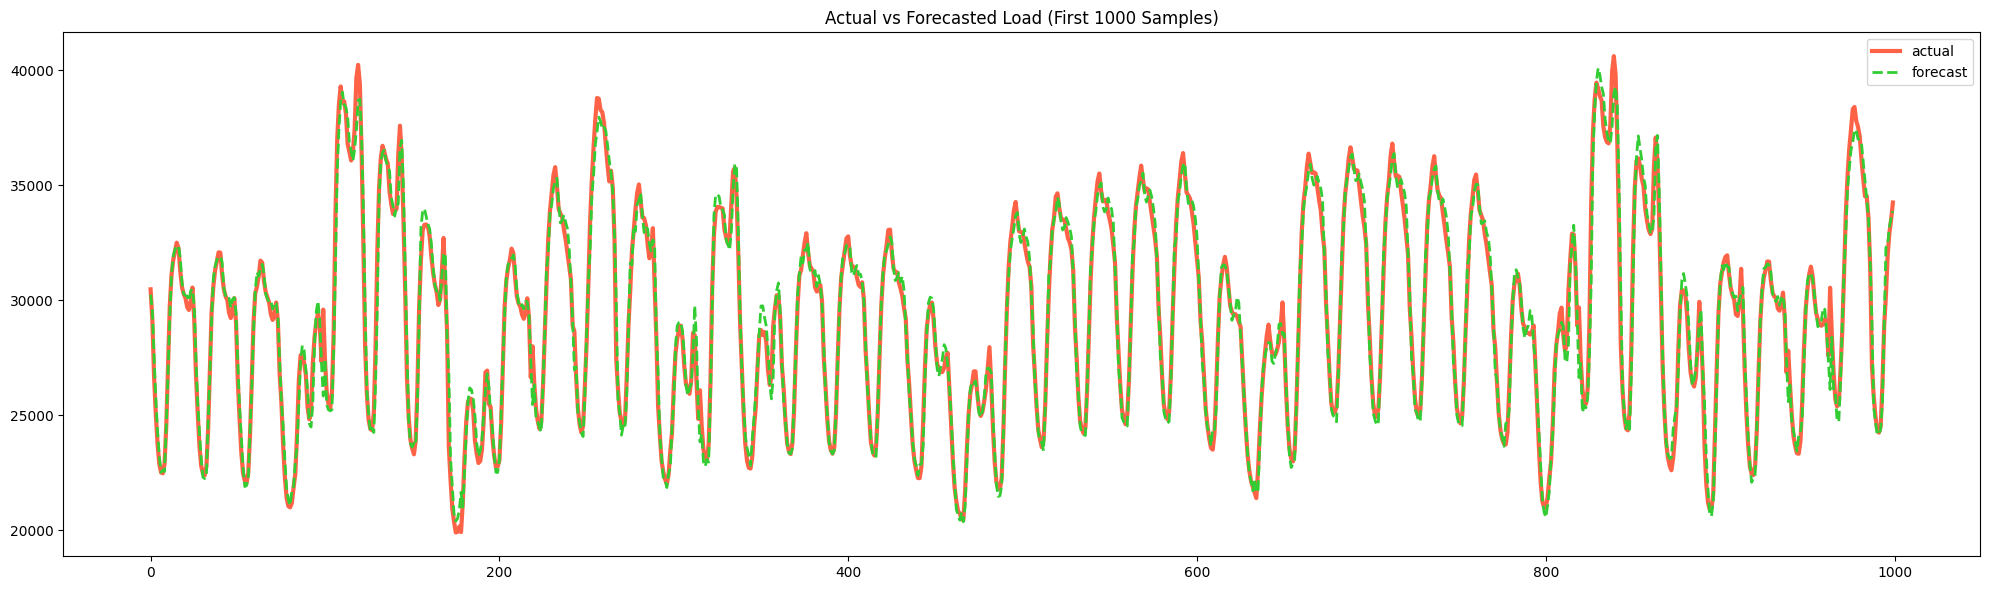

In [39]:
single_step_single_output_load_model = load_model('single step single output load model.h5')

# Forecasting
load_prediction_scaled = single_step_single_output_load_model.predict(validation_load_set_ssso)
load_actual_scaled = valid_s.iloc[window_size:]['total load actual scaled'].values

# Use the load_scaler to inverse transform the predicted values
load_prediction_original = load_scaler.inverse_transform(load_prediction_scaled)
load_actual_original =  valid.iloc[window_size:]['total load actual'].values

ssso_load_mse = mean_squared_error(load_actual_original, load_prediction_original[:])
ssso_load_mae = mean_absolute_error(load_actual_original, load_prediction_original[:])

print(f'ssso load mse: {ssso_load_mse}')
print(f'ssso load mae: {ssso_load_mae}')

#Visualize the performance
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(load_actual_original[:1000], c='Tomato', label='actual', linestyle='-', linewidth=3)
ax.plot(load_prediction_original[:1000], c= 'LimeGreen', label='forecast', linestyle='--',linewidth=2)
ax.set_title('Actual vs Forecasted Load (First 1000 Samples)')

plt.legend()
plt.tight_layout()
plt.show()

Price Model

In [40]:
output_cols = ['price actual scaled']

# Customize the price model
def create_uncompiled_price_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    return model


def create_price_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=400,
        decay_rate=0.8,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_price_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

train_price_set_ssso = single_step_windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

validation_price_set_ssso = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=None,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

validation_price_set_ssso = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=None,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)


In [ ]:
single_step_single_output_price_model = create_price_model(initial_lr=1e-1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)

history = single_step_single_output_price_model.fit(train_price_set_ssso, validation_data=validation_price_set_ssso, epochs=20, callbacks=[early_stopping])

Epoch 1/20
    655/Unknown 25s 33ms/step - loss: 0.0086 - mae: 0.0931

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


656/656 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - loss: 0.0086 - mae: 0.0931 - val_loss: 0.0044 - val_mae: 0.0823
Epoch 2/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - loss: 0.0036 - mae: 0.0656 - val_loss: 7.0892e-04 - val_mae: 0.0297
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - loss: 0.0018 - mae: 0.0467 - val_loss: 0.0013 - val_mae: 0.0432
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 0.0011 - mae: 0.0368 - val_loss: 5.4386e-04 - val_mae: 0.0263
Epoch 5/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - loss: 9.9596e-04 - mae: 0.0341 - val_loss: 5.0255e-04 - val_mae: 0.0253
Epoch 6/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - loss: 8.6962e-04 - mae: 0.0319 - val_loss: 5.8264e-04 - val_mae: 0.0272
Epoch 7/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - loss: 8.2151e-04 - mae: 0.0310 - val_loss: 0.0010 - val_mae: 0.0361
Epoch 8/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 7.7186e-04 - mae: 0.0298 - val_loss: 5.5877e-04 - val_mae: 0.0266
Epoch 9/20
656/

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
ss_price mse: 10.793887338955855
ss_price mae: 2.644858715373541


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


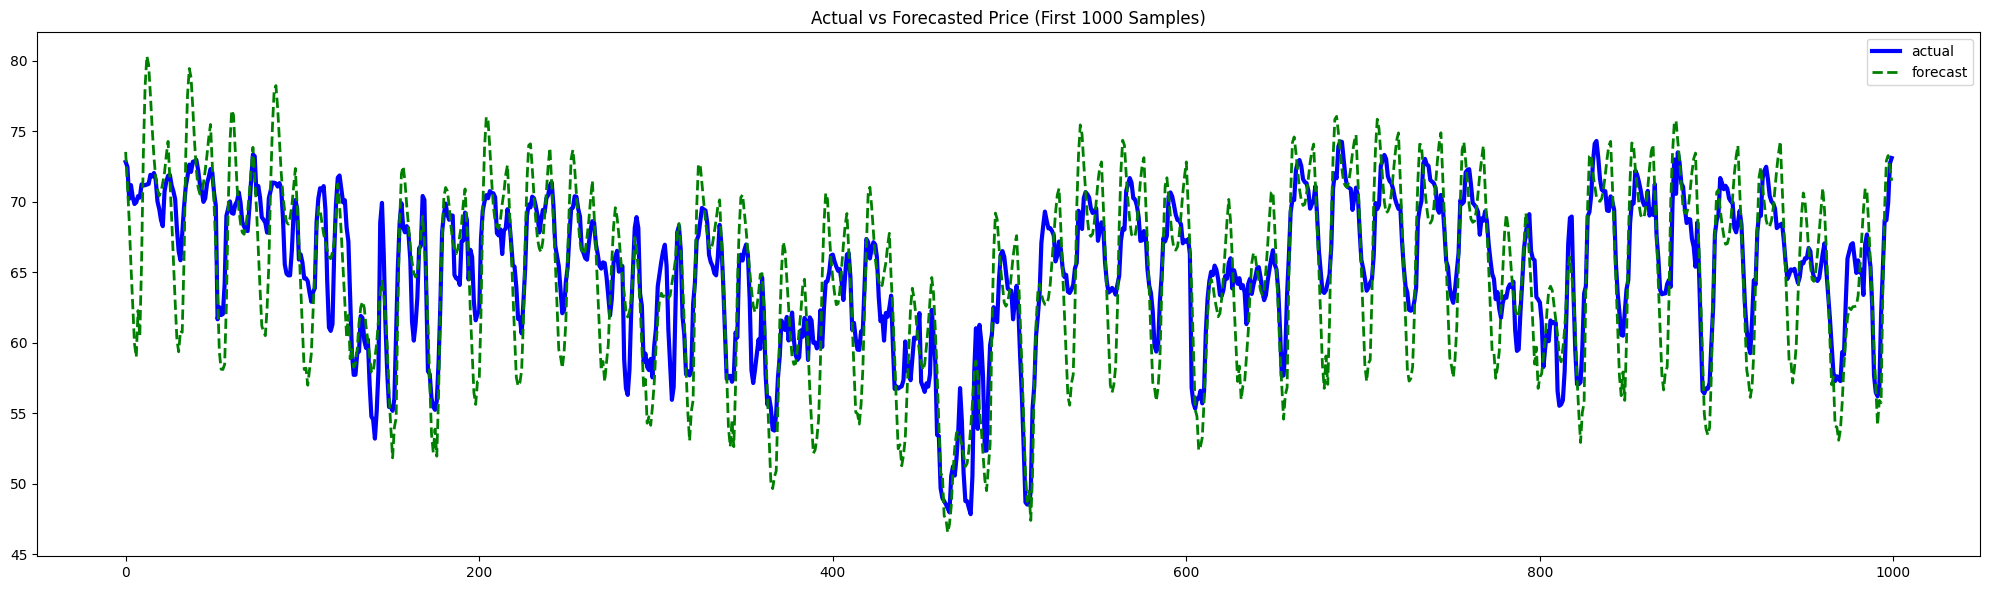

In [41]:
# Load the pretrained model
single_step_single_output_price_model = load_model('single step single output price model.h5')

# Forecast
price_prediction_scaled = single_step_single_output_price_model.predict(validation_price_set_ssso)

# Actual values
price_actual_scaled = valid_s.iloc[window_size:]['price actual scaled'].values

# Use the price_scaler to inverse transform the predicted values
price_prediction_original = price_scaler.inverse_transform(price_prediction_scaled)
price_actual_original =  valid.iloc[window_size:]['price actual'].values

# Evaluate

ss_price_scaled_mse = mean_squared_error(price_actual_scaled, price_prediction_scaled[:])
ss_price_scaled_mae = mean_absolute_error(price_actual_scaled, price_prediction_scaled[:])

ss_price_mse = mean_squared_error(price_actual_original, price_prediction_original[:])
ss_price_mae = mean_absolute_error(price_actual_original, price_prediction_original[:])

print(f'ss_price mse: {ss_price_mse}')
print(f'ss_price mae: {ss_price_mae}')

#Visualize the performance
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(price_actual_original[:1000], c='blue', label='actual', linestyle='-', linewidth=3)
ax.plot(price_prediction_original[:1000], c= 'green', label='forecast', linestyle='--', linewidth=2)
ax.set_title('Actual vs Forecasted Price (First 1000 Samples)')
plt.legend()
plt.tight_layout()
plt.show()

#single_step_single_output_price_model.save('single step single output price model.h5')

It seems that this doesn't perform as well as XGBoost.

#### Single-Step Multi-Output

In [42]:
# Customize CNN-LSTM-DNN model for both load and price
def create_uncompiled_sm_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(2),
    ])
    return model

def create_sm_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=656,
        decay_rate=0.95,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    model = create_uncompiled_sm_model()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    return model


output_cols = ['total load actual scaled', 'price actual scaled'] # predict multiple labels simultaneously
input_cols = column_names
column_names = train_s.columns.to_list()
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 24*100 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data


train_set_ssmo = single_step_windowed_dataset(
      series=train_s,
      window_size=window_size,
      batch_size=batch_size,
      shuffle_buffer_size=shuffle_buffer_size,
      input_columns=input_cols,
      output_columns=output_cols,
      column_names=column_names)

validation_set_ssmo = single_step_windowed_dataset(
      series=valid_s,
      window_size=window_size,
      batch_size=batch_size,
      shuffle_buffer_size= None,
      input_columns=input_cols,
      output_columns=output_cols,
      column_names=column_names)

test_set_ssmo = single_step_windowed_dataset(
      series=test_s,
      window_size=window_size,
      batch_size=batch_size,
      shuffle_buffer_size= None,
      input_columns=input_cols,
      output_columns=output_cols,
      column_names=column_names)

In [ ]:
single_step_multi_output_model = create_sm_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)

history = single_step_multi_output_model.fit(train_set_ssmo, validation_data=validation_set_ssmo, epochs=40, callbacks=[early_stopping])

Epoch 1/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 91s 77ms/step - loss: 0.0105 - mae: 0.1078 - val_loss: 0.0070 - val_mae: 0.0974
Epoch 2/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 74ms/step - loss: 0.0056 - mae: 0.0819 - val_loss: 0.0035 - val_mae: 0.0664
Epoch 3/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 84s 77ms/step - loss: 0.0040 - mae: 0.0693 - val_loss: 0.0030 - val_mae: 0.0613
Epoch 4/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 49s 74ms/step - loss: 0.0030 - mae: 0.0599 - val_loss: 0.0025 - val_mae: 0.0541
Epoch 5/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 85s 78ms/step - loss: 0.0023 - mae: 0.0521 - val_loss: 0.0025 - val_mae: 0.0531
Epoch 6/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - loss: 0.0021 - mae: 0.0493 - val_loss: 0.0020 - val_mae: 0.0488
Epoch 7/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 75ms/step - loss: 0.0019 - mae: 0.0469 - val_loss: 0.0020 - val_mae: 0.0474
Epoch 8/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 73ms/step - loss: 0.0017 - mae: 0.0451 - val_loss: 0.0015 - val_mae: 0.0418
Epoch 9/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 

81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


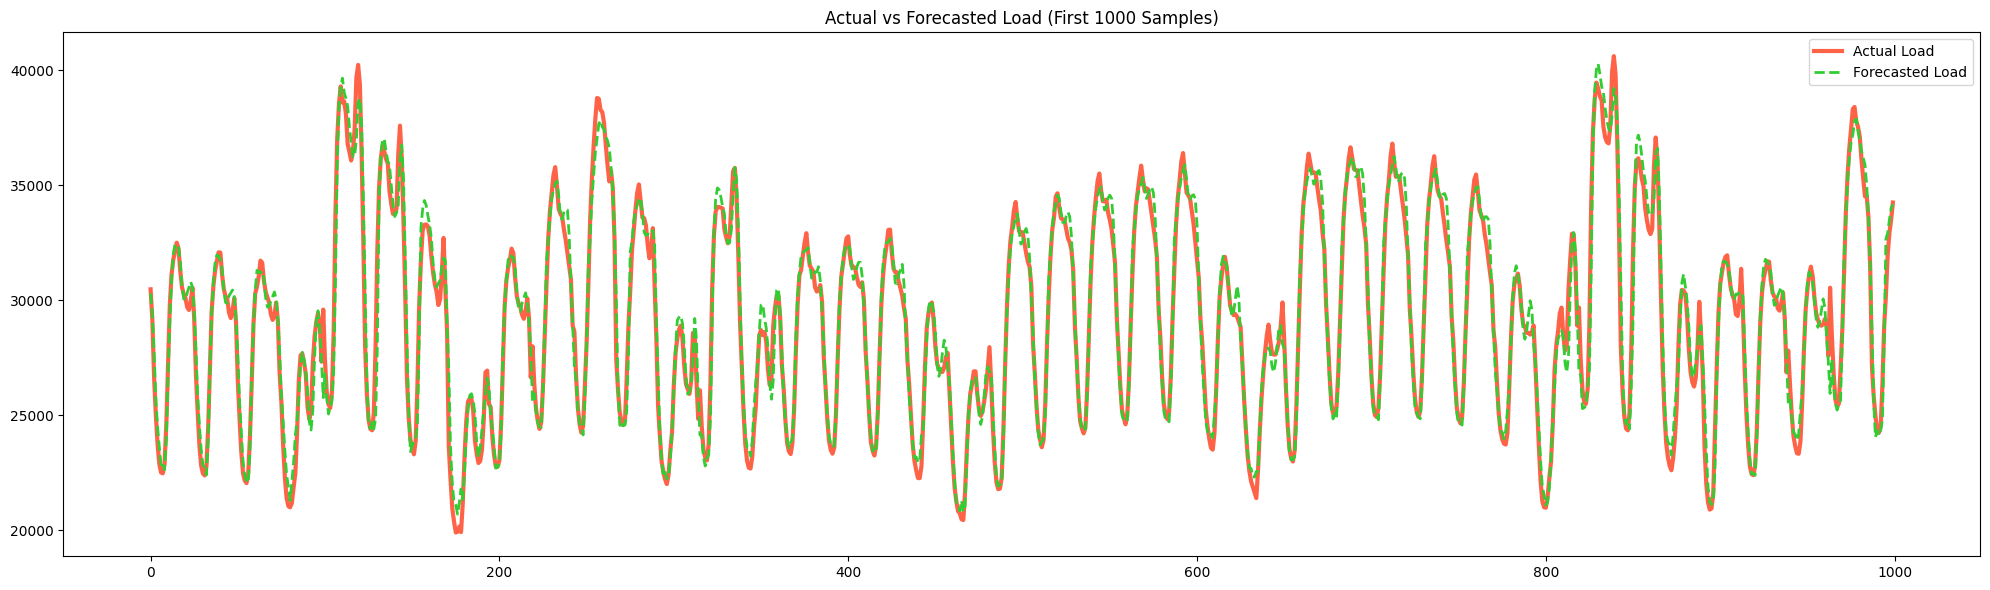

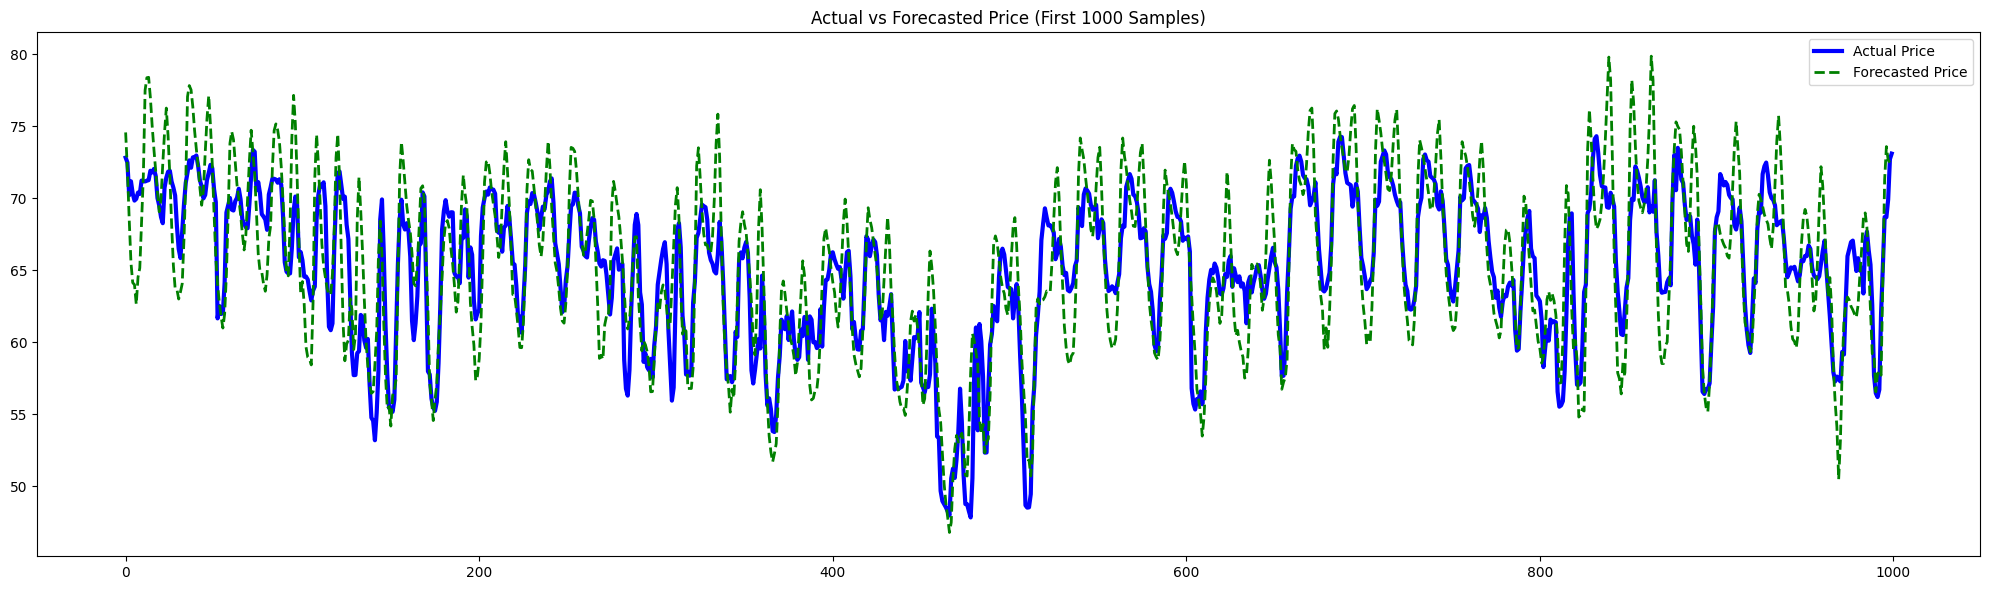

sm_load_mse: 645594.9917086934
sm_load_mae: 580.249161109363
sm_price_mse: 11.138330761564935
sm_price_mae: 2.620886313086051


In [44]:
single_step_multi_output_model = load_model('single_step_multi_output_model.h5')

forecasts = single_step_multi_output_model.predict(validation_set_ssmo)

load_prediction_scaled = forecasts[:,0].copy()
load_prediction_original = load_scaler.inverse_transform(load_prediction_scaled.reshape(-1,1))
load_actual_scaled = valid_s['total load actual scaled'][window_size:].values
load_actual_original = valid.iloc[window_size:]['total load actual'].values


price_prediction_scaled = forecasts[:,1].copy()
price_prediction_original = price_scaler.inverse_transform(price_prediction_scaled .reshape(-1,1))
price_actual_scaled = valid_s['price actual scaled'][window_size:].values
price_actual_original = valid.iloc[window_size:]['price actual'].values

sm_load_mse = mean_squared_error(load_actual_original, load_prediction_original)
sm_load_mae = mean_absolute_error(load_actual_original, load_prediction_original)
sm_price_mse = mean_squared_error(price_actual_original, price_prediction_original)
sm_price_mae = mean_absolute_error(price_actual_original, price_prediction_original)


fig, ax = plt.subplots(figsize=(20,6))
ax.plot(load_actual_original[:1000], c='Tomato', label='Actual Load', linestyle='-', linewidth=3)
ax.plot(load_prediction_original[:1000], c='LimeGreen', label='Forecasted Load', linestyle='--', linewidth=2)
ax.set_title('Actual vs Forecasted Load (First 1000 Samples)')
plt.legend()
plt.tight_layout()
plt.show()

# Visualize price actual vs prediction
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(price_actual_original[:1000], c='blue', label='Actual Price', linestyle='-', linewidth=3)
ax.plot(price_prediction_original[:1000], c='green', label='Forecasted Price', linestyle='--', linewidth=2)
ax.set_title('Actual vs Forecasted Price (First 1000 Samples)')
plt.legend()
plt.tight_layout()
plt.show()


print(f'sm_load_mse: {sm_load_mse}')
print(f'sm_load_mae: {sm_load_mae}')

print(f'sm_price_mse: {sm_price_mse}')
print(f'sm_price_mae: {sm_price_mae}')
# single_step_multi_output_model.save('single_step_multi_output_model.h5')

### 4.3 CNN-LSTM-DNN Multi Step



#### Seq2Vec (single shot)

Predict multiple time steps in a single pass

In [49]:
# Seq2vec
def windowed_dataset_s2v(series, window_size, batch_size, shuffle_buffer_size, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True) # This is different from single step model: "+ forecast_size"

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-forecast_size], input_cols, axis=-1),
                                          tf.gather(window[-forecast_size:], output_cols, axis=-1))) # forecast_size=1 refers to single step

    if shuffle_buffer_size is not None:
        dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


def create_uncompiled_s2v_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        #tf.keras.layers.Conv1D(filters=64, kernel_size=6, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.Conv1D(filters=64, kernel_size=12, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(24 * len(output_cols)),
        tf.keras.layers.Reshape([24, len(output_cols)])
    ])
    return model

def create_s2v_model():  # Adam works well with a smaller learning rate
    # Set the optimizer to Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # Compile the model
    model = create_uncompiled_s2v_model()
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

# Parameters

input_cols = train_s.columns.to_list()
output_cols = ['total load actual scaled', 'price actual scaled']
column_names = train_s.columns.to_list()

window_size = 24 * 7
batch_size = 32
shuffle_buffer_size = 4000 # this value depends on the size of the data, around the len(data) for small data and small len(data) for big data
forecast_size = 24


train_set_s2v = windowed_dataset_s2v(train_s, window_size,
                             batch_size,
                             shuffle_buffer_size,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)

valid_set_s2v = windowed_dataset_s2v(series = valid_s,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer_size = None,
                             forecast_size = forecast_size,
                             input_cols = input_cols,
                             output_cols = output_cols,
                             column_names = column_names)

test_set_s2v = windowed_dataset_s2v(series = test_s,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer_size = None,
                             forecast_size = forecast_size,
                             input_cols = input_cols,
                             output_cols = output_cols,
                             column_names = column_names)

In [ ]:
s2v_model = create_s2v_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

history = s2v_model.fit(train_set_s2v, validation_data=valid_set_s2v, epochs=30, callbacks=[early_stopping])

# s2v_model.save('s2v_model.h5')



In [53]:
s2v_model = load_model('s2v_model.h5')

# Forecasting
valid_predictions =s2v_model.predict(valid_set_s2v)
# Actual values
valid_actual_labels = np.concatenate([y for x, y in valid_set_s2v.as_numpy_iterator()])

# Load
predicted_load = valid_predictions[:, :, 0].reshape(-1, 1)
predicted_load_original = load_scaler.inverse_transform(predicted_load).reshape(valid_predictions.shape[0], valid_predictions.shape[1])

actual_load_scaled = valid_actual_labels[:, :, 0].reshape(-1, 1)
actual_load_original = load_scaler.inverse_transform(actual_load_scaled).reshape(valid_predictions.shape[0], valid_predictions.shape[1])


# Price
predicted_price = valid_predictions[:, :, 1].reshape(-1, 1)
predicted_price_original = price_scaler.inverse_transform(predicted_price).reshape(valid_predictions.shape[0], valid_predictions.shape[1])

actual_price_scaled = valid_actual_labels[:, :, 1].reshape(-1, 1)
actual_price_original = price_scaler.inverse_transform(actual_price_scaled).reshape(valid_predictions.shape[0], valid_predictions.shape[1])

# Evaluation
# To save time, we only select a subset of the validation set for evaluation, consistent with the XGBoost case.
s2v_eval_load_prediction = predicted_load_original[:24*30]
s2v_eval_price_prediction = predicted_price_original[:24*30]

s2v_eval_load_actual = actual_load_original[:24*30]
s2v_eval_price_actual = actual_price_original[:24*30]

v_s2v_load_mae = mean_absolute_error(s2v_eval_load_actual, s2v_eval_load_prediction)
v_s2v_load_mse = mean_squared_error(s2v_eval_load_actual, s2v_eval_load_prediction)

v_s2v_price_mae = mean_absolute_error(s2v_eval_price_actual, s2v_eval_price_prediction)
v_s2v_price_mse = mean_squared_error(s2v_eval_price_actual, s2v_eval_price_prediction)


print(f"V Load MAE: {v_s2v_load_mae}")
print(f"V Load MSE: {v_s2v_load_mse}")

print(f"V Price MAE: {v_s2v_price_mae}")
print(f"V Price MSE: {v_s2v_price_mse}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


V Load MAE: 1304.3709716796875
V Load MSE: 3445172.75
V Price MAE: 3.9600155353546143
V Price MSE: 24.439163208007812


Test

In [54]:
# Forecasting
test_predictions =s2v_model.predict(test_set_s2v)
# Actual values
test_actual_labels = np.concatenate([y for x, y in test_set_s2v.as_numpy_iterator()])

# Load
predicted_load = test_predictions[:, :, 0].reshape(-1, 1)
predicted_load_original = load_scaler.inverse_transform(predicted_load).reshape(test_predictions.shape[0], test_predictions.shape[1])

actual_load_scaled = test_actual_labels[:, :, 0].reshape(-1, 1)
actual_load_original = load_scaler.inverse_transform(actual_load_scaled).reshape(test_predictions.shape[0], test_predictions.shape[1])


# Price
predicted_price = test_predictions[:, :, 1].reshape(-1, 1)
predicted_price_original = price_scaler.inverse_transform(predicted_price).reshape(test_predictions.shape[0], test_predictions.shape[1])

actual_price_scaled = test_actual_labels[:, :, 1].reshape(-1, 1)
actual_price_original = price_scaler.inverse_transform(actual_price_scaled).reshape(test_predictions.shape[0], test_predictions.shape[1])

# Evaluation
# To save time, we only select a subset of test set for evaluation, consistent with the XGBoost case.
s2v_test_load_prediction = predicted_load_original[:24*30]
s2v_test_price_prediction = predicted_price_original[:24*30]

s2v_test_load_actual = actual_load_original[:24*30]
s2v_test_price_actual = actual_price_original[:24*30]

t_s2v_load_mae = mean_absolute_error(s2v_test_load_actual, s2v_test_load_prediction)
t_s2v_load_mse = mean_squared_error(s2v_test_load_actual, s2v_test_load_prediction)

t_s2v_price_mae = mean_absolute_error(s2v_test_price_actual, s2v_test_price_prediction)
t_s2v_price_mse = mean_squared_error(s2v_test_price_actual, s2v_test_price_prediction)


print(f"Test Load MAE: {t_s2v_load_mae}")
print(f"Test Load MSE: {t_s2v_load_mse}")

print(f"Test Price MAE: {t_s2v_price_mae}")
print(f"Test Price MSE: {t_s2v_price_mse}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Test Load MAE: 1679.5302734375
Test Load MSE: 6094391.5
Test Price MAE: 5.325869083404541
Test Price MSE: 42.355308532714844


#### Seq2Seq

In [57]:
# Seq2seq

def windowed_dataset_s2s(series, window_size, batch_size, shuffle_buffer_size, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True) # This is different from single step model: "+ forecast_size"

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    dataset = dataset.map(lambda window: (
        # Encoder input: the past time steps for the encoder (window_size)
        tf.gather(window[:window_size], input_cols, axis=-1),

        # Decoder targets: gather the next forecast_size steps for each step in the window
        tf.stack([tf.gather(window[i+1:i+1+forecast_size], output_cols, axis=-1)
                  for i in range(window_size)])
    ))


    if shuffle_buffer_size is not None:
        dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


def create_uncompiled_s2s_model():
    """Creates an uncompiled sequential model with Conv1D, LSTM, and Dense layers.

    Returns:
        model (Sequential): Uncompiled Keras Sequential model.
    """

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu',
                               input_shape=[None, len(input_cols)]),
        tf.keras.layers.Conv1D(filters=64, kernel_size=12, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(forecast_size * len(output_cols))),
        tf.keras.layers.Reshape((window_size, forecast_size, len(output_cols)))
    ])

    return model

def create_s2s_model():  # Adam works well with a smaller learning rate
    # Set the optimizer to Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # Compile the model
    model = create_uncompiled_s2s_model()
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

input_cols = train_s.columns.to_list()
output_cols = ['total load actual scaled', 'price actual scaled']
column_names = train_s.columns.to_list()

# Parameters
window_size = 24*7
batch_size = 32
shuffle_buffer_size = 4000 # this value depends on the size of the data, around the len(data) for small data and small len(data) for big data
forecast_size = 24


train_set_s2s = windowed_dataset_s2s(train_s, window_size,
                             batch_size,
                             shuffle_buffer_size,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)
valid_set_s2s = windowed_dataset_s2s(valid_s,
                             window_size,
                             batch_size,
                             None,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)
test_set_s2s = windowed_dataset_s2s(test_s,
                             window_size,
                             batch_size,
                             None,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)

In [ ]:
s2s_model = create_s2s_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True)

history = s2s_model.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[early_stopping])
#s2s_model.save('s2s_model.h5')

In [60]:
s2s_model = tf.keras.models.load_model('s2s_model.h5')

# Forecasting
val_predictions = s2s_model.predict(valid_set_s2s)

# Load
load_prediction_scaled = val_predictions[:,-1,:,0] # take only the final step's load prediction, the last 24 forecasts
load_prediction_original = load_scaler.inverse_transform(load_prediction_scaled)

loads = np.concatenate([y for x, y in valid_set.as_numpy_iterator()]) # Actual values
load_actual_scaled = loads[:,-1,:,0]
load_actual_original = load_scaler.inverse_transform(load_actual_scaled)


# Price
price_prediction_scaled = val_predictions[:,-1,:,1]
price_prediction_original = price_scaler.inverse_transform(price_prediction_scaled)

prices = np.concatenate([y for x, y in valid_set.as_numpy_iterator()]) # Actual values
price_actual_scaled = prices[:,-1,:,1]
price_actual_original = price_scaler.inverse_transform(price_actual_scaled)


# Evaluation
# We select a subset of the validation set for evaluation, consistant with the XGBoost case
s2s_eval_load_prediction = load_prediction_original[:24*30]
s2s_eval_price_prediction = price_prediction_original[:24*30]
s2s_eval_load_actual = load_actual_original[:24*30]
s2s_eval_price_actual = price_actual_original[:24*30]


v_s2s_load_mse = mean_squared_error(s2s_eval_load_actual, s2s_eval_load_prediction)
v_s2s_load_mae = mean_absolute_error(s2s_eval_load_actual, s2s_eval_load_prediction)
v_s2s_price_mse = mean_squared_error(s2s_eval_price_actual, s2s_eval_price_prediction)
v_s2s_price_mae = mean_absolute_error(s2s_eval_price_actual, s2s_eval_price_prediction)

print(f"V Load MAE: {v_s2s_load_mae}")
print(f"V Load MSE: {v_s2s_load_mse}")
print(f"V Price MAE: {v_s2s_price_mae}")
print(f"V Price MSE: {v_s2s_price_mse}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


V Load MAE: 1212.6505126953125
V Load MSE: 3167761.0
V Price MAE: 3.545147657394409
V Price MSE: 20.263832092285156


In [62]:
# Forecasting
test_predictions = s2s_model.predict(test_set_s2s)

# Load
load_prediction_scaled = test_predictions[:,-1,:,0] # take only the final step's load prediction, the last 24 forecasts
load_prediction_original = load_scaler.inverse_transform(load_prediction_scaled)

loads = np.concatenate([y for x, y in test_set_s2s.as_numpy_iterator()]) # Actual values
load_actual_scaled = loads[:,-1,:,0]
load_actual_original = load_scaler.inverse_transform(load_actual_scaled)


# Price
price_prediction_scaled = test_predictions[:,-1,:,1]
price_prediction_original = price_scaler.inverse_transform(price_prediction_scaled)

prices = np.concatenate([y for x, y in test_set_s2s.as_numpy_iterator()]) # Actual values
price_actual_scaled = prices[:,-1,:,1]
price_actual_original = price_scaler.inverse_transform(price_actual_scaled)


# Evaluation
# We select a subset of the validation set for evaluation, consistant with the XGBoost case
s2s_test_load_prediction = load_prediction_original[:24*30]
s2s_test_price_prediction = price_prediction_original[:24*30]
s2s_test_load_actual = load_actual_original[:24*30]
s2s_test_price_actual = price_actual_original[:24*30]


t_s2s_load_mse = mean_squared_error(s2s_test_load_actual, s2s_test_load_prediction)
t_s2s_load_mae = mean_absolute_error(s2s_test_load_actual, s2s_test_load_prediction)
t_s2s_price_mse = mean_squared_error(s2s_test_price_actual, s2s_test_price_prediction)
t_s2s_price_mae = mean_absolute_error(s2s_test_price_actual, s2s_test_price_prediction)

print(f"Test Load MAE: {t_s2s_load_mae}")
print(f"Test Load MSE: {t_s2s_load_mse}")
print(f"Test Price MAE: {t_s2s_price_mae}")
print(f"Test Price MSE: {t_s2s_price_mse}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Test Load MAE: 1625.0882568359375
Test Load MSE: 5786029.5
Test Price MAE: 5.171972751617432
Test Price MSE: 41.0770149230957


## 5-Evaluation

#### Single-Step Model Evaluation
By evaluating the three single-step models, we select the best one for further multi-step forecasting using an Autoregressive Forecasting approach.

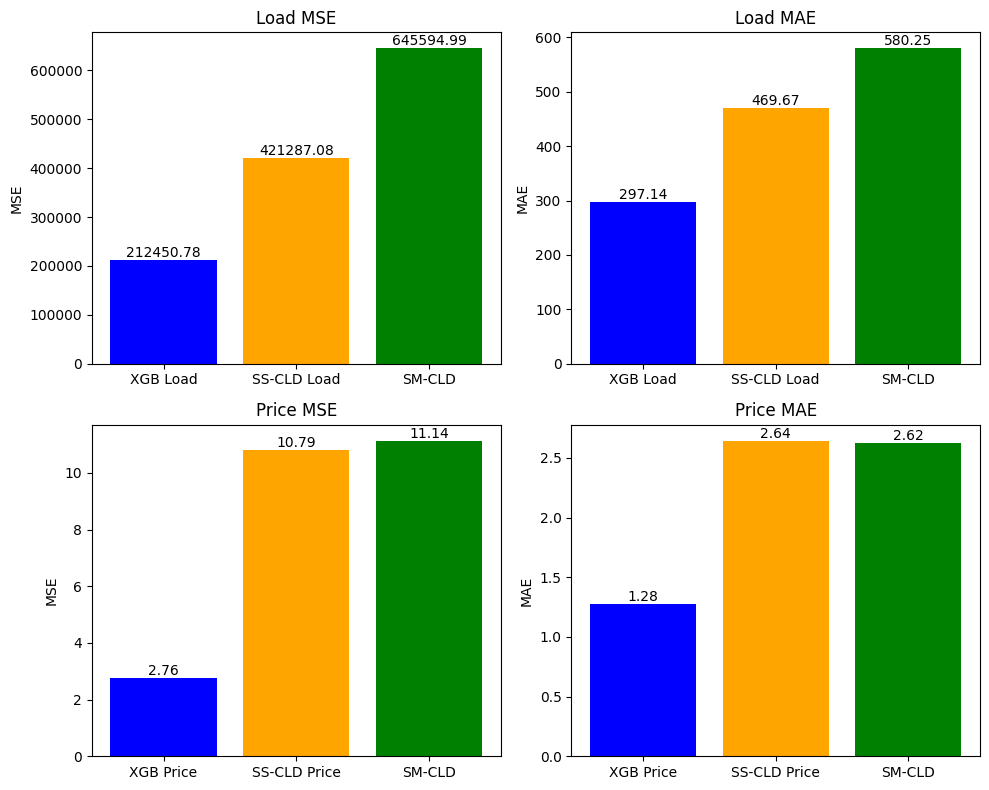

In [63]:
colors = ['blue', 'orange', 'green']

# Reorder to have XGB first
load_mse_values = [xgb_load_mse, ss_load_mse, sm_load_mse]
load_mae_values = [xgb_load_mae, ss_load_mae, sm_load_mae]

price_mse_values = [xgb_price_mse, ss_price_mse, sm_price_mse]
price_mae_values = [xgb_price_mae, ss_price_mae, sm_price_mae]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Load MSE
bars = axs[0, 0].bar(['XGB Load', 'SS-CLD Load', 'SM-CLD'], load_mse_values, color=colors)
axs[0, 0].set_title('Load MSE')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].bar_label(bars, fmt='%.2f')

# Load MAE
bars = axs[0, 1].bar(['XGB Load', 'SS-CLD Load', 'SM-CLD'], load_mae_values, color=colors)
axs[0, 1].set_title('Load MAE')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].bar_label(bars, fmt='%.2f')

# Price MSE
bars = axs[1, 0].bar(['XGB Price', 'SS-CLD Price', 'SM-CLD'], price_mse_values, color=colors)
axs[1, 0].set_title('Price MSE')
axs[1, 0].set_ylabel('MSE')
axs[1, 0].bar_label(bars, fmt='%.2f')

# Price MAE
bars = axs[1, 1].bar(['XGB Price', 'SS-CLD Price', 'SM-CLD'], price_mae_values, color=colors)
axs[1, 1].set_title('Price MAE')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].bar_label(bars, fmt='%.2f')

plt.tight_layout()
plt.show()


The results above indicate that XGBoost significantly outperforms the other models, and therefore, we will proceed with XGBoost for further autoregressive forecasting. Additionally, I have demonstrated the results of the single-step single-output CNN-LSTM-DNN (SS_CLD) and single-step multi-output CNN-LSTM-DNN (SM_CLD) models in a separate notebook, which you can view here: link.

#### Autoregressive Forecasting

(XGBoost autoregressive forecasting)

In [142]:
feature_names = train_x.columns.to_list()

In [145]:
def xgb_autoregressive_forecast(load_model, price_model, last_row, forecast_size=24, lag_size=48, rolling_size=8):
    load_pre = np.zeros(forecast_size, dtype=np.float32)
    price_pre = np.zeros(forecast_size, dtype=np.float32)

    # Extract scalar values using .iloc[0]
    load_lags = np.array([last_row[f'total load actual lag_{i}'].iloc[0] for i in range(1, lag_size + 1)], dtype=np.float32)
    price_lags = np.array([last_row[f'price actual lag_{i}'].iloc[0] for i in range(1, lag_size + 1)], dtype=np.float32)
    load_rolling_lags = np.array([last_row[f'total load actual rolling lag_{i}'].iloc[0] for i in range(1, lag_size + 1)], dtype=np.float32)
    price_rolling_lags = np.array([last_row[f'price actual rolling lag_{i}'].iloc[0] for i in range(1, lag_size + 1)], dtype=np.float32)

    # Time features
    hour = last_row['hour'].iloc[0]
    day_of_week = last_row['dayofweek'].iloc[0]

    # Precompute indices
    num_features = 2 + lag_size * 4  # 2 for hour and day_of_week, 4 for each lag feature
    hour_idx = 0
    day_of_week_idx = 1
    lags_start_idx = 2

    # Preallocate the features array
    features = np.zeros(num_features, dtype=np.float32)

    for t in range(forecast_size):
        # Assign time features
        features[hour_idx] = hour
        features[day_of_week_idx] = day_of_week

        # Assign lag features using NumPy slicing
        features[lags_start_idx::4] = load_lags
        features[lags_start_idx + 1::4] = price_lags
        features[lags_start_idx + 2::4] = load_rolling_lags
        features[lags_start_idx + 3::4] = price_rolling_lags

        # Prepare the data for prediction
        features_reshaped = features.reshape(1, -1)

        # Create DMatrix without specifying feature_names to reduce overhead
        dmatrix_input = xgb.DMatrix(features_reshaped, feature_names=feature_names)

        # Make predictions
        predicted_load = load_model.predict(dmatrix_input)[0]
        predicted_price = price_model.predict(dmatrix_input)[0]

        load_pre[t] = predicted_load
        price_pre[t] = predicted_price

        # Update lag features
        load_lags[1:] = load_lags[:-1]
        load_lags[0] = predicted_load

        load_rolling_lags[1:] = load_rolling_lags[:-1]
        load_rolling_lags[0] = load_lags[:rolling_size].mean()

        price_lags[1:] = price_lags[:-1]
        price_lags[0] = predicted_price

        price_rolling_lags[1:] = price_rolling_lags[:-1]
        price_rolling_lags[0] = price_lags[:rolling_size].mean()

        # Update time features
        hour = (hour + 1) % 24
        if hour == 0:
            day_of_week = (day_of_week + 1) % 7

    return load_pre, price_pre


def xgb_generate_rolling_forecast(load_model, price_model, data, forecast_size=24, lag_size=48, rolling_size=8, n_jobs=1):
    num_rows = len(data)
    # Preallocate arrays for predictions
    all_load_predictions = np.zeros((num_rows, forecast_size), dtype=np.float32)
    all_price_predictions = np.zeros((num_rows, forecast_size), dtype=np.float32)

    def process_row(idx):
        last_row = data.iloc[idx:idx+1]
        load_pre, price_pre = xgb_autoregressive_forecast(
            load_model,
            price_model,
            last_row=last_row,
            forecast_size=forecast_size,
            lag_size=lag_size,
            rolling_size=rolling_size
        )
        return idx, load_pre, price_pre

    for idx in range(num_rows):
        idx_result, load_pre, price_pre = process_row(idx)
        all_load_predictions[idx_result] = load_pre
        all_price_predictions[idx_result] = price_pre

    # Return the NumPy arrays directly
    return all_load_predictions, all_price_predictions


# Create overlapping windows of historical data
def create_rolling_window(dataset, window_size=24):
    """
    Converts a 1D dataset into a 2D dataset with a rolling window.

    This function is useful in time series forecasting, where it helps
    create overlapping windows of historical data for training models that
    require fixed-size input sequences, such as RNNs, LSTMs, or CNNs.

    Parameters:
    dataset (pd.Series or np.array): The input 1D array or series.
    window_size (int): The size of the rolling window (number of steps).

    Returns:
    np.array: A 2D array where each row contains the next 'window_size' values.
    """
    rolling_window = np.lib.stride_tricks.sliding_window_view(dataset, window_size)

    return rolling_window

In [146]:
# Forecasting

# For simplicity, we selected a subset of the validation set consisting of 30 days (24*30 steps)
eval_sample_input = valid_x.iloc[24*5:24*5+24*30].copy()
eval_sample_load = valid_load[24*5:24*5+24*30+23].copy()
eval_sample_price = valid_price[24*5:24*5+24*30+23].copy()

load_pred_df, price_pred_df = xgb_generate_rolling_forecast(
    load_model=xgb_load_final_model,
    price_model=xgb_price_final_model,
    data=eval_sample_input,
    forecast_size=24,
    lag_size=48,
    rolling_size=8
)

# Evaluation

xgb_load_actual = create_rolling_window(eval_sample_load.to_numpy(), window_size=24)
xgb_price_actual = create_rolling_window(eval_sample_price.to_numpy(), window_size=24)

v_xgb_autoregressive_load_mae = mean_absolute_error(xgb_load_actual, load_pred_df)
v_xgb_autoregressive_load_mse = mean_squared_error(xgb_load_actual, load_pred_df)

v_xgb_autoregressive_price_mae = mean_absolute_error(xgb_price_actual, price_pred_df)
v_xgb_autoregressive_price_mse = mean_squared_error(xgb_price_actual, price_pred_df)

print(f"xgb autoregressive mse: {v_xgb_autoregressive_load_mse}")
print(f"xgb autoregressive mae: {v_xgb_autoregressive_load_mae}")

print(f"xgb autoregressive price mse: {v_xgb_autoregressive_price_mse}")
print(f"xgb autoregressive price mae: {v_xgb_autoregressive_price_mae}")


xgb autoregressive mse: 3181045.211426843
xgb autoregressive mae: 1175.424464699074
xgb autoregressive price mse: 14.835743727691353
xgb autoregressive price mae: 2.9936414613282216


In [148]:
# For simplicity, we selected a subset of the validation set consisting of 30 days (24*30 steps)
test_sample_input = test_x.iloc[24*5:24*5+24*30].copy()
test_sample_load = test_load[24*5:24*5+24*30+23].copy()
test_sample_price = test_price[24*5:24*5+24*30+23].copy()

load_pred_forecast, price_pred_forecast = xgb_generate_rolling_forecast(
    load_model=xgb_load_final_model,
    price_model=xgb_price_final_model,
    data=test_sample_input,
    forecast_size=24,
    lag_size=48,
    rolling_size=8
)


# Evaluation

xgb_load_actual_test = create_rolling_window(test_sample_load.to_numpy(), window_size=24)
xgb_price_actual_test = create_rolling_window(test_sample_price.to_numpy(), window_size=24)

t_xgb_autoregressive_load_mae = mean_absolute_error(xgb_load_actual_test, load_pred_forecast)
t_xgb_autoregressive_load_mse = mean_squared_error(xgb_load_actual_test, load_pred_forecast)

t_xgb_autoregressive_price_mae = mean_absolute_error(xgb_price_actual_test, price_pred_forecast)
t_xgb_autoregressive_price_mse = mean_squared_error(xgb_price_actual_test, price_pred_forecast)

print(f"xgb autoregressive mse: {t_xgb_autoregressive_load_mse}")
print(f"xgb autoregressive mae: {t_xgb_autoregressive_load_mae}")

print(f"xgb autoregressive price mse: {t_xgb_autoregressive_price_mse}")
print(f"xgb autoregressive price mae: {t_xgb_autoregressive_price_mae}")

xgb autoregressive mse: 3092780.848615359
xgb autoregressive mae: 1215.4554742883754
xgb autoregressive price mse: 31.635649650593734
xgb autoregressive price mae: 4.277885547955834


#### Final Model Evaluation and Selection

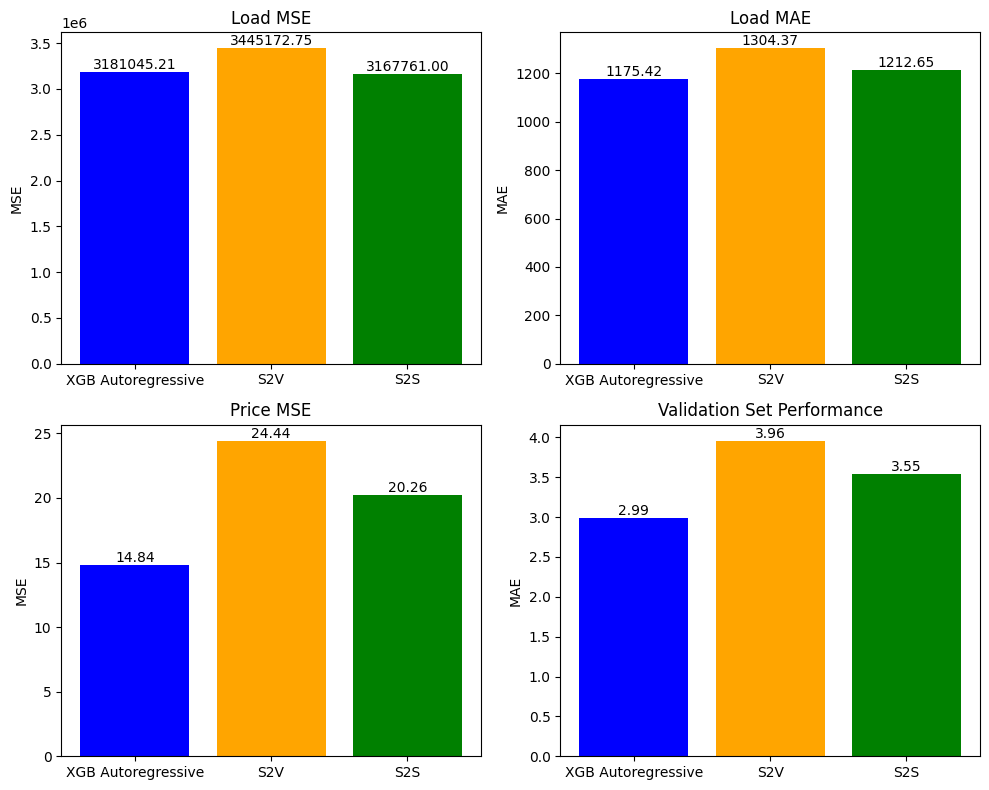

In [150]:
# Visualizing the performance of three models: XGBoost+Autoregressive, seq2vec CLD, seq2seq CLD


# Evaluation on validation set

# Colors for the bars
colors = ['blue', 'orange', 'green']

# Load MSE and MAE values for each method
load_mse_values = [v_xgb_autoregressive_load_mse, v_s2v_load_mse, v_s2s_load_mse]
load_mae_values = [v_xgb_autoregressive_load_mae, v_s2v_load_mae, v_s2s_load_mae]

# Price MSE and MAE values for each method
price_mse_values = [v_xgb_autoregressive_price_mse, v_s2v_price_mse, v_s2s_price_mse]
price_mae_values = [v_xgb_autoregressive_price_mae, v_s2v_price_mae, v_s2s_price_mae]

# Create subplots for the comparisons
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Load MSE bar chart
bars = axs[0,0].bar(['XGB Autoregressive', 'S2V', 'S2S'], load_mse_values, color=colors)
axs[0,0].set_title('Load MSE')
axs[0,0].set_ylabel('MSE')
axs[0,0].bar_label(bars, fmt='%.2f')

# Load MAE bar chart
bars = axs[0,1].bar(['XGB Autoregressive', 'S2V', 'S2S'], load_mae_values, color=colors)
axs[0,1].set_title('Load MAE')
axs[0,1].set_ylabel('MAE')
axs[0,1].bar_label(bars, fmt='%.2f')

# Price MSE bar chart
bars = axs[1,0].bar(['XGB Autoregressive', 'S2V', 'S2S'], price_mse_values, color=colors)
axs[1,0].set_title('Price MSE')
axs[1,0].set_ylabel('MSE')
axs[1,0].bar_label(bars, fmt='%.2f')

# Price MAE bar chart
bars = axs[1,1].bar(['XGB Autoregressive', 'S2V', 'S2S'], price_mae_values, color=colors)
axs[1,1].set_title('Price MAE')
axs[1,1].set_ylabel('MAE')
axs[1,1].bar_label(bars, fmt='%.2f')

# Adjust layout and show the plot
plt.title('Validation Set Performance')
plt.tight_layout()
plt.show()



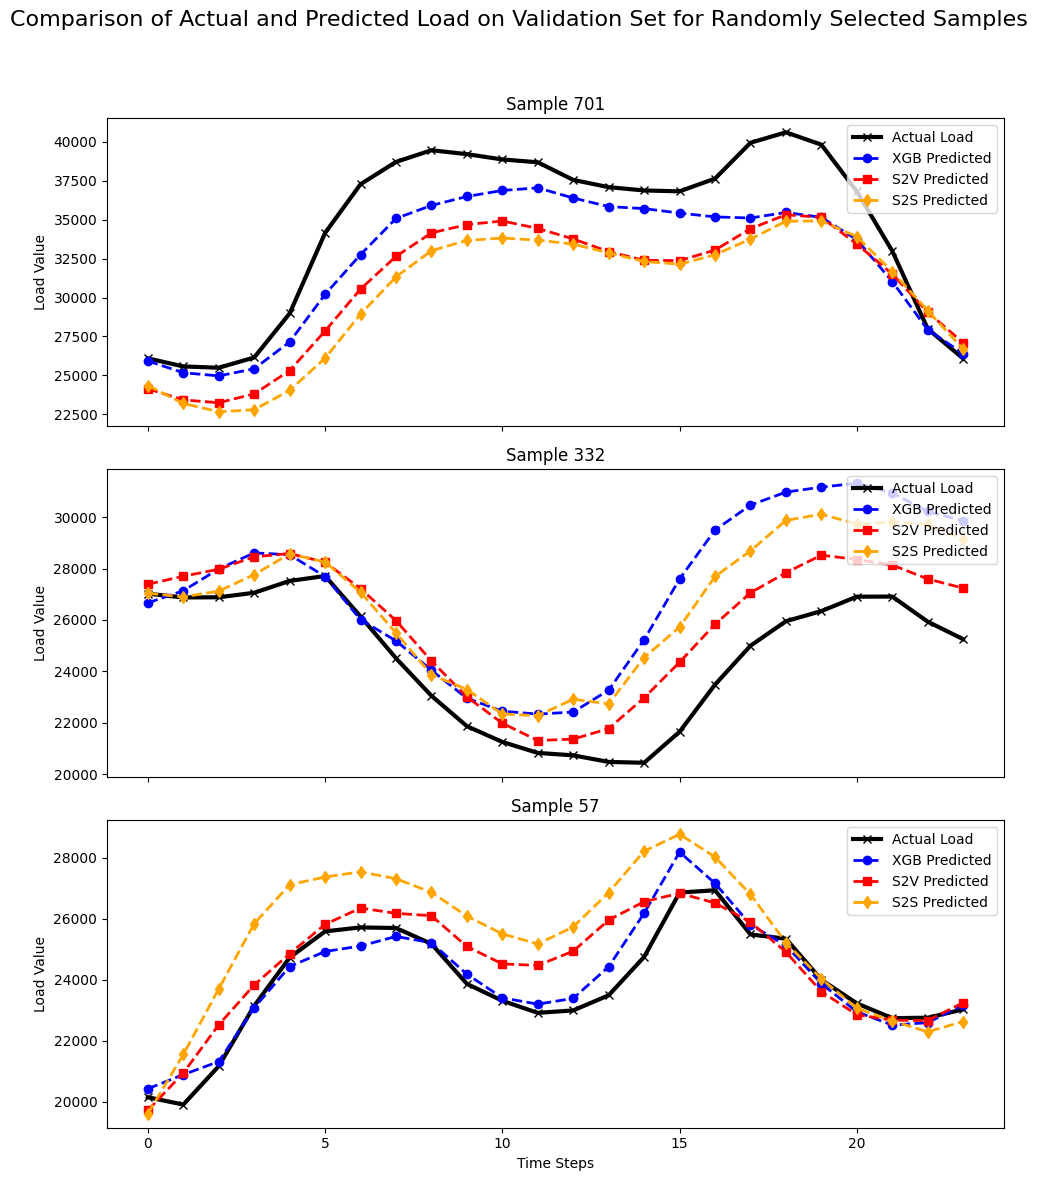

In [154]:
# Visualization

num_samples = len(xgb_load_actual)

# Randomly select 3 sample indices
random_numbers = 3
selected_indices = random.sample(range(num_samples), random_numbers)

# Create 3 subplots, all sharing the same X-axis
fig, axs = plt.subplots(random_numbers, 1, figsize=(10, 12), sharex=True)  # Increased figure size for better display

for i, n in enumerate(selected_indices):
    # Plot actual values and predicted values
    axs[i].plot(xgb_load_actual[n], label='Actual Load', linestyle='-', marker='x', c='black', linewidth=3)
    axs[i].plot(load_pred_df[n], label='XGB Predicted', linestyle='--', marker='o', c='blue', linewidth=2)
    axs[i].plot(s2v_eval_load_prediction[n], label='S2V Predicted', linestyle='--', marker='s', c='red', linewidth=2)
    axs[i].plot(s2s_eval_load_prediction[n], label='S2S Predicted', linestyle='--', marker='d', c='orange',linewidth=2)

    # Set a simple title for each subplot
    axs[i].set_title(f'Sample {n}')

    # Set consistent Y-axis limits for easier comparison
    #axs[i].set_ylim([min(eval_load_rolled[n]) - 2000, max(eval_load_rolled[n]) + 2000])

    # Set Y-axis label
    axs[i].set_ylabel('Load Value')

    axs[i].legend(loc='upper right')

# Add a global title for the entire figure
fig.suptitle('Comparison of Actual and Predicted Load on Validation Set for Randomly Selected Samples', fontsize=16)

# Set X-axis label for time steps
plt.xlabel('Time Steps')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Auto-adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the global title


# Display the plot
plt.show()


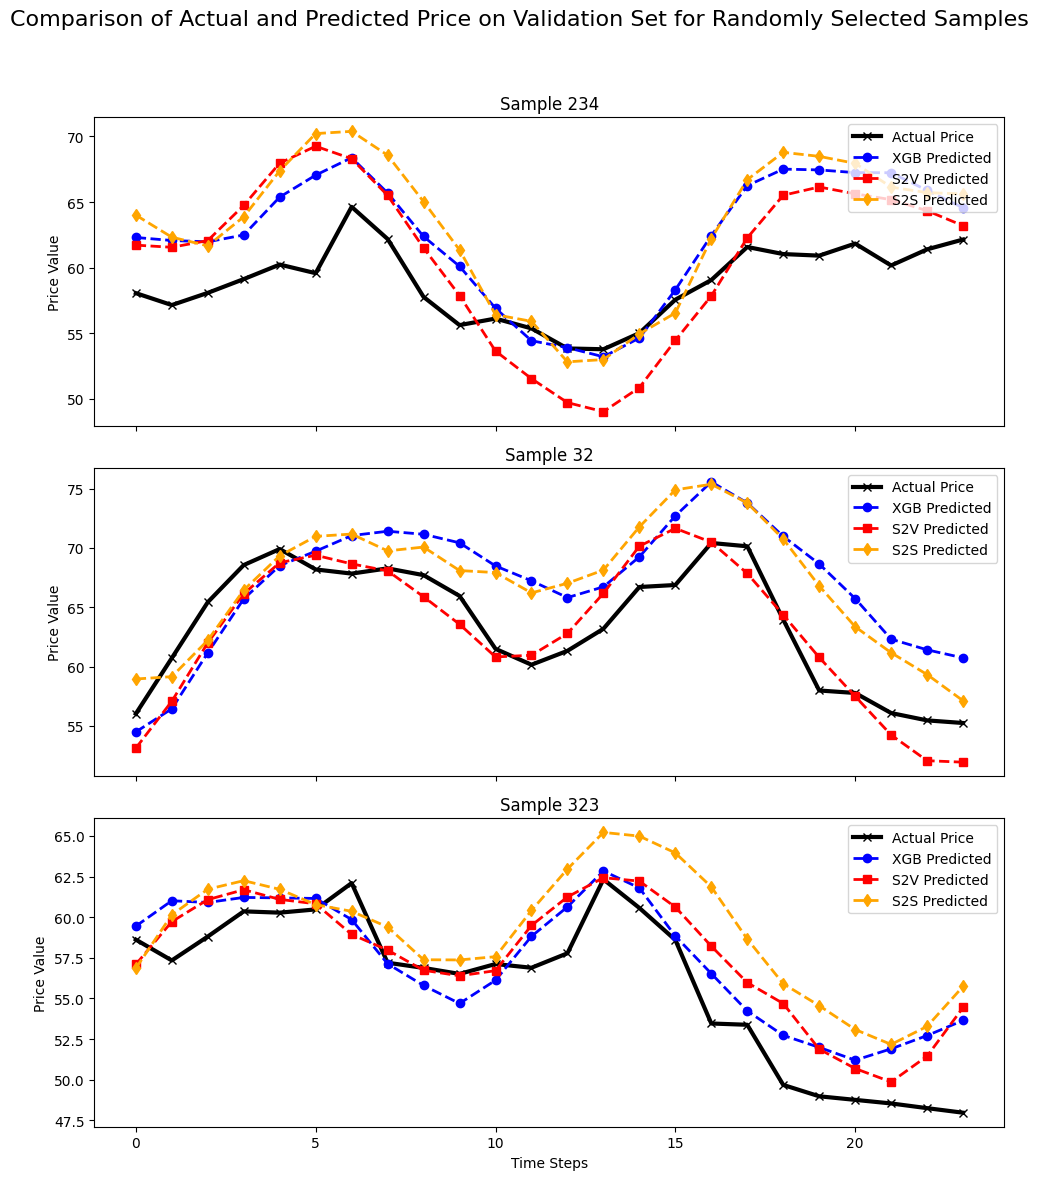

In [155]:
# Visualization

num_samples = len(xgb_price_actual)

# Randomly select 3 sample indices
random_numbers = 3
selected_indices = random.sample(range(num_samples), random_numbers)

# Create 3 subplots, all sharing the same X-axis
fig, axs = plt.subplots(random_numbers, 1, figsize=(10, 12), sharex=True)  # Increased figure size for better display

for i, n in enumerate(selected_indices):
    # Plot actual values and predicted values
    axs[i].plot(xgb_price_actual[n], label='Actual Price', linestyle='-', marker='x', c='black', linewidth=3)
    axs[i].plot(price_pred_df[n], label='XGB Predicted', linestyle='--', marker='o', c='blue', linewidth=2)
    axs[i].plot(s2v_eval_price_prediction[n], label='S2V Predicted', linestyle='--', marker='s', c='red', linewidth=2)
    axs[i].plot(s2s_eval_price_prediction[n], label='S2S Predicted', linestyle='--', marker='d', c='orange',linewidth=2)

    # Set a simple title for each subplot
    axs[i].set_title(f'Sample {n}')

    # Set consistent Y-axis limits for easier comparison
    #axs[i].set_ylim([min(eval_load_rolled[n]) - 2000, max(eval_load_rolled[n]) + 2000])

    # Set Y-axis label
    axs[i].set_ylabel('Price Value')

    axs[i].legend(loc='upper right')

# Add a global title for the entire figure
fig.suptitle('Comparison of Actual and Predicted Price on Validation Set for Randomly Selected Samples', fontsize=16)

# Set X-axis label for time steps
plt.xlabel('Time Steps')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Auto-adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the global title


# Display the plot
plt.show()


Now, let's move on to evaluate these three models on test dataset

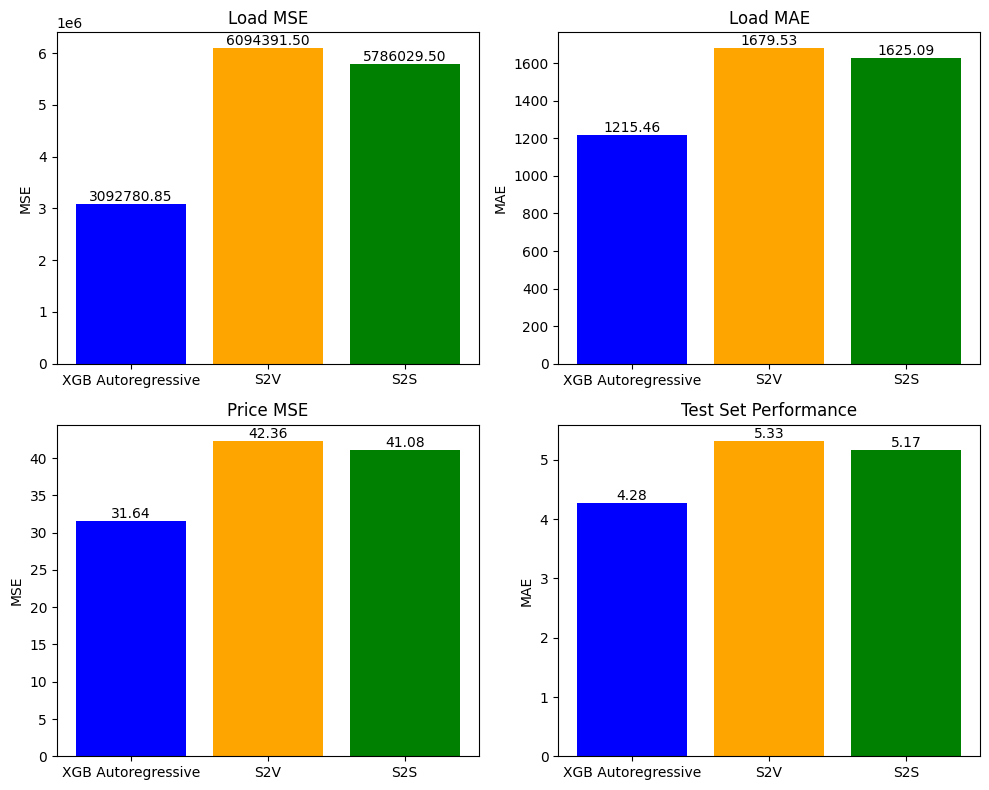

In [157]:
# Visualizing the performance of three models: XGBoost+Autoregressive, seq2vec CLD, seq2seq CLD


# Evaluation on test set

# Colors for the bars
colors = ['blue', 'orange', 'green']

# Load MSE and MAE values for each method
load_mse_values = [t_xgb_autoregressive_load_mse, t_s2v_load_mse, t_s2s_load_mse]
load_mae_values = [t_xgb_autoregressive_load_mae, t_s2v_load_mae, t_s2s_load_mae]

# Price MSE and MAE values for each method
price_mse_values = [t_xgb_autoregressive_price_mse, t_s2v_price_mse, t_s2s_price_mse]
price_mae_values = [t_xgb_autoregressive_price_mae, t_s2v_price_mae, t_s2s_price_mae]

# Create subplots for the comparisons
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Load MSE bar chart
bars = axs[0,0].bar(['XGB Autoregressive', 'S2V', 'S2S'], load_mse_values, color=colors)
axs[0,0].set_title('Load MSE')
axs[0,0].set_ylabel('MSE')
axs[0,0].bar_label(bars, fmt='%.2f')

# Load MAE bar chart
bars = axs[0,1].bar(['XGB Autoregressive', 'S2V', 'S2S'], load_mae_values, color=colors)
axs[0,1].set_title('Load MAE')
axs[0,1].set_ylabel('MAE')
axs[0,1].bar_label(bars, fmt='%.2f')

# Price MSE bar chart
bars = axs[1,0].bar(['XGB Autoregressive', 'S2V', 'S2S'], price_mse_values, color=colors)
axs[1,0].set_title('Price MSE')
axs[1,0].set_ylabel('MSE')
axs[1,0].bar_label(bars, fmt='%.2f')

# Price MAE bar chart
bars = axs[1,1].bar(['XGB Autoregressive', 'S2V', 'S2S'], price_mae_values, color=colors)
axs[1,1].set_title('Price MAE')
axs[1,1].set_ylabel('MAE')
axs[1,1].bar_label(bars, fmt='%.2f')

# Adjust layout and show the plot
plt.title('Test Set Performance')
plt.tight_layout()
plt.show()



## 5. Deployment and Prediction